# Birdcall Identification
Here I hope to be able to make a model to predict the type of bird based on metadata sourced from recordings of birdcalls, including location, date/time, and frequency data extracted from Discrete Fourier Transformation and frequency spectrograms from Short Term Fourier Transformations.


We will be making use of a few different libraries outside of the normal anaconda distrobution. We will only install individual dependencies used in this project here. I use a rebuild of conda called micromamba to organize my virtual enviroment, but you can replace `micromamba` with `conda` in any command I use to do the same thing with a traditional anaconda distrobution.
```bash
micromamba create -p ./.conda ipykernel pandas numpy scipy matplotlib scikit-learn cupy ffmpeg
micromamba activate ./.conda
pip install pydub
```

`ipykernel`, `pandas`, `numpy`, `scipy`, and `matplotlib` are all part of anaconda.
`cupy` is a remake of `numpy` and `scipy` that makes use of nvidias cuda toolkit to perform calulations on the gpu with cuda capable cpus.
`ffmpeg` is a tool for converting and decoding a variety of different audio and video codecs that will be used to decoding mp3 files.
`pydub` is a python library for dealing with audio files in a shorthand manner. `pydub` uses `ffmpeg` automatically for mp3 decoding if it is avaliable.

## Importing and Understanding our data

### Downloading Data
The first data source is from a [kaggle competition](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/), and has most of the data preorganized for us. This can also be downloaded by running this code after accepting the terms of the competition on a valid kaggle account:
```bash
kaggle competitions download -c birdsong-recognition
```

The Dataset includes in it a large set of mp3 files organized by individual bird. each bird is assigned an ebird code, this appears to be something widly used by the Cornell Lab of Ornithology where this data originated, and the mp3 files are organized in folders with their ebird code. The file train.csv contains information about the mp3 files.

```log
.
├── example_test_audio
│  ├── BLKFR-10-CPL_20190611_093000.pt540.mp3
│  └── ORANGE-7-CAP_20190606_093000.pt623.mp3
├── example_test_audio_metadata.csv
├── example_test_audio_summary.csv
├── sample_submission.csv
├── test.csv
├── train.csv
└── train_audio
   ├── aldfly
   │  ├── XC2628.mp3
   │  └── ...
   ├── ameavo
   │  ├── XC99571.mp3
   │  └── ...
   ├── amebit
   │  ├── XC127371.mp3
   │  └── ...
   ├── amecro
   │  ├── XC51410.mp3
   │  └── ...
   ├── amegfi
   │  ├── XC17120.mp3
   │  └── ...
   ├── amekes
   │  ├── XC16111.mp3
   │  └── ...
   └── ...
```

In [413]:
import time
import os
import asyncio
import sys
import pandas as pd
import numpy as np
import scipy as sp
import cupy as cp
import cupyx as cpx
import cupyx.scipy.fft as cufft
import cupyx.scipy.signal as cusig
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.utils import mediainfo

# turn warnings off
import warnings
warnings.filterwarnings("ignore")

In [414]:
df = pd.read_csv('data/birdsong-recognition/train.csv')
df.head()

rating playback_used ebird_code    channels        date          pitch  \
0     3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
2     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
3     3.5            no     aldfly  2 (stereo)  2013-05-27           both   
4     4.0            no     aldfly  2 (stereo)  2013-05-27           both   

   duration      filename          speed           species  ...   xc_id  \
0        25  XC134874.mp3  Not specified  Alder Flycatcher  ...  134874   
1        36  XC135454.mp3           both  Alder Flycatcher  ...  135454   
2        39  XC135455.mp3           both  Alder Flycatcher  ...  135455   
3        33  XC135456.mp3           both  Alder Flycatcher  ...  135456   
4        36  XC135457.mp3          level  Alder Flycatcher  ...  135457   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   
2  https://www.xeno-canto.org/135455  United States       Mike Nelson   
3  https://www.xeno-canto.org/135456  United States       Mike Nelson   
4  https://www.xeno-canto.org/135457  United States       Mike Nelson   

                        primary_label longitude         length   time  \
0  Empidonax alnorum_Alder Flycatcher   -92.962  Not specified   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
2  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
3  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
4  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   

          recordist                                            license  
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0  
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
2       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
3       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
4       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 35 columns]

While this does list the individual species of the bird, it doesnt give me the full taxonomy of the bird in the file. I expect the number of indidual species of birds here to be very high which will make if more difficult to train a classification model on.

In [415]:
df.species.nunique()

264

So I would like the option to be able to detect something less specific than the actual species, if I could detect the correct order or family of bird that could still prove valuable and would have a smaller sample of options to classify. I searched for a dataset of species of birds with their full taxonomy, and I found [this](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/) dataset that seems to be from the same organization that put together the birdsong data.

In [416]:
taxonomy = pd.read_csv('data/ebird_taxonomy_v2023.csv')
taxonomy.head()

TAXON_ORDER CATEGORY SPECIES_CODE  TAXON_CONCEPT_ID       PRIMARY_COM_NAME  \
0            2  species      ostric2  avibase-2247CB05         Common Ostrich   
1            7  species      ostric3  avibase-40329BB6         Somali Ostrich   
2            8    slash       y00934  avibase-5D14080C  Common/Somali Ostrich   
3           10  species      grerhe1  avibase-00986B24           Greater Rhea   
4           16  species      lesrhe2  avibase-590ADF92            Lesser Rhea   

                         SCI_NAME             ORDER  \
0                Struthio camelus  Struthioniformes   
1          Struthio molybdophanes  Struthioniformes   
2  Struthio camelus/molybdophanes  Struthioniformes   
3                  Rhea americana        Rheiformes   
4                    Rhea pennata        Rheiformes   

                      FAMILY SPECIES_GROUP REPORT_AS  
0  Struthionidae (Ostriches)     Ostriches       NaN  
1  Struthionidae (Ostriches)     Ostriches       NaN  
2  Struthionidae (Ostriches)     Ostriches       NaN  
3            Rheidae (Rheas)         Rheas       NaN  
4            Rheidae (Rheas)         Rheas       NaN

From here because we know we are dealing with a lot of data, even though we are still in the early stages before things start getting out of hand, I'm going to begin tracking how much data is contained in our dataframes, just so we can see when things are getting unruly.

In [417]:
def memory_usage(name, df):
    memory = df.memory_usage(deep=True).sum()
    print(f'{name} Memory Usage: {bytes_to_human_readable(memory)}')

def bytes_to_human_readable(n):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if n < 1024:
            return f"{n:.2f} {unit}"
        n /= 1024
    return f"{n:.2f} PB"

In [418]:
memory_usage('Training Data', df)
memory_usage('Taxonomy', taxonomy)

Training Data Memory Usage: 44.53 MB
Taxonomy Memory Usage: 9.36 MB


Its worth noting, this is roughly 3.5 times more data than the raw csv alone. We will want to keep an eye on this

### Veryifying the datasets match
Before we begin perminantly combining these datasets, first lets verify that these data sets are compatible with eachother. First Lets make sure the `SPECIES_CODE` column contains only unique values. This dataset contains more than just species, and I want to know for sure that one species has a unique species code.

In [419]:
total_species_codes = len(taxonomy['SPECIES_CODE'])
unique_species_codes = taxonomy['SPECIES_CODE'].nunique()
print('All values in SPECIES_CODE are unique:', total_species_codes == unique_species_codes)
del total_species_codes, unique_species_codes
    

All values in SPECIES_CODE are unique: True


Now I'll make sure that for the `SPECIES_CODE` column in the `taxonomy` dataframe refers to the same `ebird_code` listed by the main dataframe. To do this I will make sure that the when the `taxonomy.SPECIES_CODE` and `df.ebird_code` match that the `taxonomy.SCI_NAME` and `df.sci_name` also match.

To make this computation happen faster, I'm going to merge the two dataframes on that `ebird_code` column, that way we only need to iterate through the dataframe once to be able to check the needed files.

In [420]:
# Merge the taxonomy data with the training data
df = df.merge(taxonomy, left_on='ebird_code', right_on='SPECIES_CODE', how='left', indicator=True)
# Get the ebird_codes that did not merge or have a scientific name mismatch between the two datasets
bad_codes = df[(df['_merge'] == 'left_only') | (df['sci_name'] != df['SCI_NAME'])]['ebird_code'].unique()

# Iterate through the bad codes and print out the scientific names that do not match
for code in bad_codes:
    if code not in taxonomy['SPECIES_CODE'].values:
        print(code, "not found in taxonomy")
    else:
        sci_name_mismatch = df[(df['ebird_code'] == code) & (df['sci_name'] != df['SCI_NAME'])]
        for _, row in sci_name_mismatch.iterrows():
            print(code, "SCI_NAME mismatch")
            print(row['SCI_NAME'], '!=', row['sci_name'])
            print("Row number:", row.name)

print("Bad codes:", bad_codes)
del bad_codes

doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7087
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7088
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7089
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7090
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7091
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7092
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7093
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7094
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7095
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7096
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7097
doccor SCI_NAME mismatch
Nannopterum auritu

While that did print out a lot of individual problem rows, there were only 5 indivudal codes that did not seem to match: 
`['doccor' 'evegro' 'haiwoo' 'pasfly' 'ruckin']`

Upon manual examination I found that while the two datasets disagree over the scientific name, they do all agree on the common name for the bird. As well when looking up the birds on wikipedia, in all cases I found one of the listed scientific names under the 'Synonyms' section. The important thing is not which name is 'correct', but just that the `ebird_code` and `SPECIES_CODE` are refering to the same thing, which we have proven here. 

Since we know the codes refer to the same species of bird, we can completely ignore all of the species information from the original dataframe and only use the species information from the taxonomy dataset, because it contains more useful information for our needs.

### Understanding our Merged Data

In [421]:
print(df.columns)
memory_usage('Merged Data', df)

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license', 'TAXON_ORDER', 'CATEGORY', 'SPECIES_CODE',
       'TAXON_CONCEPT_ID', 'PRIMARY_COM_NAME', 'SCI_NAME', 'ORDER', 'FAMILY',
       'SPECIES_GROUP', 'REPORT_AS', '_merge'],
      dtype='object')
Merged Data Memory Usage: 55.96 MB


In [422]:
df = df.drop(columns=['_merge', 'playback_used', 'pitch', 'speed',
                      'species', 'number_of_notes', 'title', 'secondary_labels',
                      'bird_seen', 'sci_name', 'location', 'description',
                      'bitrate_of_mp3', 'volume', 'background', 'xc_id',
                      'url', 'country', 'author', 'primary_label',
                      'length', 'recordist', 'license', 'TAXON_ORDER',
                      'CATEGORY', 'SPECIES_CODE', 'TAXON_CONCEPT_ID', 'REPORT_AS'])
df.rename(columns={'PRIMARY_COM_NAME': 'common_name', 
                   'SCI_NAME': 'sci_name', 
                   'ORDER': 'order', 
                   'FAMILY': 'family', 
                   'SPECIES_GROUP': 'species_group'}, inplace=True)
print(df.columns)
memory_usage('Merge Data', df)
del taxonomy

Index(['rating', 'ebird_code', 'channels', 'date', 'duration', 'filename',
       'latitude', 'sampling_rate', 'type', 'elevation', 'file_type',
       'longitude', 'time', 'common_name', 'sci_name', 'order', 'family',
       'species_group'],
      dtype='object')
Merge Data Memory Usage: 20.00 MB


What we are left with is a dataframe with only features that intuitively feel like they may be valuable for a model to train off of or may be useful to us in other orginizational ways:
 - `rating`: It may prove to be valuable to filter out some less desirable files in the training data. This may be a good feature to filter by
 - `ebird_code`: This is a potential target to train a model to classify. This will have an individual value for every species
 - `channels`: This may be needed when normalizing data from audio files
 - `date`: Some birds may be more likely to be heard in specific times of the year. The date of the recording may provide some insite on the types of birds that are most likely to be heard
 - `duration`: This may prove to be useful to keep in the data for calculations that arent directly tied to features.
 - `filename`: This will be needed to access data about the waveform itself.
 - `latitude`/`longitude`: These two features in conjunction with eachother could provide helpful insite based on which birds are present where.
 - `sampling_rate`: This may be useful for metadata when performing foyer transformations to ensure that frequency maps display correctly.
 - `type`: This is the type of sound that is being heard, ie a call, or drumming, or a scream. This would probably need to be cleaned up or engineered in some way but could be helpful in conjunction with frequency data to help understand what is being listened for. (This however is not something that could be given as easily as a predictor)
 - `elevation`: This could potentially have similar value to latitude and longitude, and may be used as a 3rd axis in that group.
 - `file_type`: This may be nessicary when organizing data files and making sure they are displaying the same as eachother.
 - `time`: This refers to the time of day of the recording. This may be useful training data because some calls may be more likely to happen at specific times of the day.
 - `common_name`: This should be 1 to 1 with ebird_codes, and could provide the same use, but with a human readable and understandable output.
 - `sci_name`: This matches the values of the common_name
 - `family`: This is the family that the species belongs to. This is a potential target that has fewer unique values than trying to target an individual species
 - `order`: This is the order that the species belongs to. This is a potential target that has fewer unique values than trying to target a family of species.
 - `species_group`: This is the human understandable group that the species belong to. In many cases I believe this actually follows the family but is human readable and understandable.

For all of the potential targets, lets print out how many unique values there are so we know how many individual classifers we will need.

In [423]:
print('common_name:', df['common_name'].nunique())
print('sci_name:', df['sci_name'].nunique())
print('order:', df['order'].nunique())
print('family:', df['family'].nunique())
print('species_group:', df['species_group'].nunique())

common_name: 264
sci_name: 264
order: 17
family: 50
species_group: 45


Each of these represent potential targets for our classification model. Detecting for each unique species is ideal but has 264 possible outputs. Detecting Species groups is very human understandable and still useful, and only contains 45 options, but that is still a lot. Detecting the Order has only 17 possible outputs, but the birds also may prove to be less and less correlated to eachother in terms of call.

### Working with audio
Most of the audio data can be manipulated with the pydub library, especially since we are given mp3 files and not something lossless.

In [424]:
file_path = 'data/birdsong-recognition/train_audio/aldfly/XC2628.mp3'
bird_sound = AudioSegment.from_file(file_path, format=mediainfo(file_path)['format_name'])
del file_path

# Print the length of the audio file in milliseconds
print(f'Length: {len(bird_sound)}')

# Print the sample rate of the audio file
print(f'Sample Rate: {bird_sound.frame_rate}')

# Print the number of channels in the audio file
print(f'Channels: {bird_sound.channels}')

# Print the Bit Depth of the audio 
# This is not accessable from the sound file itself, and is found from pydub.utils import mediainfo
print(f'Bit Depth: {mediainfo("data/birdsong-recognition/train_audio/aldfly/XC2628.mp3").get('sample_fmt', '')}')

new_sound = bird_sound[500:1500] + bird_sound[500:1500] + bird_sound[500:1500] + bird_sound[500:1500] + bird_sound[500:1500]
new_sound.export("exports/preview1.wav", format="wav")
del new_sound

Length: 15256
Sample Rate: 44100
Channels: 1
Bit Depth: fltp


This now provides a very simple playback system for working with audio data. the AudioSegment object are immutable and have a very simple syntax for basic operations. Audio can be spliced like this a python list, where the index marks the number of miliseconds from the start of the file, Audio can also be concatinated with other audio with a simple `+` operator, but all changes must be written to another variable because All AudioSegment objects are immutable.

Sound can be played with the library simpleaudio installed but we can preview all audio in browser so it is accessable to the reader without setting up the enviroment.
Here is the audio file loaded in the `sound` variable

<audio controls>
  <source src="https://xeno-canto.org/sounds/uploaded/KOIEAHGHNX/79/b07.mp3" type="audio/mpeg">
Your browser does not support the audio element, but trust my the audio played back and it sounded like a bird.
</audio>

And here is the audio file we made from `new_sound`

<audio controls>
  <source src="exports/preview1.wav" type="audio/wav">
Your browser does not support the audio element, but trust my the audio played back and it sounded like a bird.
</audio>

### Verifying all Data

In [425]:
def scale_value(input_value, input_min=0, input_max=100, output_min=0, output_max=120):
    # Normalize the input value to a range of 0 to 1
    normalized_input = (input_value - input_min) / (input_max - input_min)
    
    # Apply an exponential function to create a non-linear scale
    scaled_value = (np.exp(normalized_input) - 1) / (np.e - 1)

    # Apply an exponential function to create a non-linear scale
    scaled_value = (np.exp(scaled_value) - 1) / (np.e - 1)
    
    # Map the scaled value to the output range
    output_value = output_min + scaled_value * (output_max - output_min)
    
    return output_value

# Function to print a progress bar that updates in place
def print_progress_bar(iteration, length, display_handler=None, message='', convert_to_human_readable=False):
    progress = iteration / length
    progress = int(progress * 100)
    # Determine color based on progress using a CSS gradient
    color = f'hsl({scale_value(progress)}, 100%, 50%)'
    bar = f'<span style="color: {color};">{"=" * progress}</span>{' ' * (100 - progress)}'
    if convert_to_human_readable:
        iteration = bytes_to_human_readable(iteration)
        length = bytes_to_human_readable(length)
    style = 'font-family: monospace; font-size: 13px;'
    if message:
        message = f'<pre style="{style}">[{bar}] - {iteration}/{length} - {message}</pre>'
    else:
        message = f'<pre style="{style}">[{bar}] - {iteration}/{length}</pre>'
    if not display_handler:
        display_handler = display(HTML(message), display_id=True)
    else:
        display_handler.update(HTML(message))
    return display_handler


def time_to_human_readable(seconds, depth=3):
    if depth == 0 or depth == 1:
        return f'{seconds:.2f} seconds'
    if depth == 2:
        minutes, seconds = divmod(seconds, 60)
        return f'{int(minutes):02}:{int(seconds):02}'
    hours, rem = divmod(seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    return f'{int(hours):02}:{int(minutes):02}:{int(seconds):02}'


def calculate_time_remaining(start_time, iteration, length):
    elapsed_time = time.time() - start_time
    iterations_remaining = length - iteration
    time_per_iteration = elapsed_time / iteration
    time_remaining = iterations_remaining * time_per_iteration
    time_remaining_str = time_to_human_readable(time_remaining)
    return time_remaining_str

def print_boundry(message):
    length = (100 - len(message)) // 2
    print('-' * length, message, '-' * length)

def get_audio(bird, file):
    try:
        file_path = f'data/birdsong-recognition/train_audio/{bird}/{file}'
        sound = AudioSegment.from_file(file_path, format=mediainfo(file_path)['format_name'])
        return bird, file, sound
    except:
        print(f'Error loading {bird}/{file}', end='\033[K')
        return bird, file, None

async def decompress_audio(bird, file):
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, get_audio, bird, file)

async def process_files(bird, files):
    tasks = [decompress_audio(bird, file) for file in files]
    return await asyncio.gather(*tasks)

Check the data for anomolies here. find the mysterious file types like the wav files listed as mp3 files and the mp2 files if you want

In [426]:
print_boundry('Processing Audio Files')
display_handler = None
start_time = time.time()
total_count = 0
bird_count = 0
# Create a new dataframe with all the columns from the original dataframe
df.rename(columns={'channels': 'channel'}, inplace=True)
new_df = pd.DataFrame(columns=df.columns)
# Add the collumn bit rate to the dataframe
old_records = None
new_df['bit_depth'] = np.nan
new_df['array_size'] = np.nan
if os.path.exists('exports/audio.csv'):
    old_records = pd.read_csv('exports/audio.csv')
    new_df = old_records.copy()
for bird in df['ebird_code'].unique():
    bird_count += 1
    count = 0
    bird_time = time.time()
    # If csv file already exists, skip the bird
    if old_records is not None:
        if bird in old_records.ebird_code.unique():
            total_count += len(df[df.ebird_code == bird])
            message = f'{bird} - {bird_count}/{len(df.ebird_code.unique())}'
            display_handler = print_progress_bar(len(df[df.ebird_code == bird]),
                                                 len(df[df.ebird_code == bird]),
                                                 display_handler=display_handler,
                                                 message=message)
            continue
    for bird, file, sound in await process_files(bird, df[df['ebird_code'] == bird].filename.values):
        count += 1
        total_count += 1
        if sound is None:
            continue
        for i in range(sound.channels):
            row = df[(df.ebird_code == bird) & (df.filename == file)].iloc[0].copy()
            row.filename = f'data/birdsong-recognition/train_audio/{bird}/{file}'
            row.channel = i
            row.duration = len(sound) / 1000
            row.sampling_rate = sound.frame_rate
            row['bit_depth'] = mediainfo(row.filename).get('sample_fmt', '')
            mono_sound = sound.split_to_mono()[i]
            row['array_size'] = np.array(mono_sound.get_array_of_samples()).nbytes
            new_df.loc[len(new_df)] = row
        message = f'{bird} - {bird_count}/{len(df.ebird_code.unique())} - {calculate_time_remaining(start_time, total_count, len(df))}'
        display_handler = print_progress_bar(count,
                                              len(df[df.ebird_code == bird]),
                                              display_handler=display_handler,
                                              message=message)
    new_df.to_csv('exports/audio.csv', index=False)
time_to_complete = time_to_human_readable(time.time() - start_time)
display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">Time to complete: {time_to_complete} seconds</pre>'))
print_boundry('Complete')

del start_time, total_count, bird_count, bird_time, count, new_df, old_records, df
df = pd.read_csv('exports/audio.csv')

--------------------------------------- Processing Audio Files ---------------------------------------


---------------------------------------------- Complete ----------------------------------------------


This took 55 minutes to run on a machine with an Intel Core i5 9600K processor. This tells me that the act of decoding MP3 files will prove to be quite a heavy bottleneck in performance.

## Feature Engineering

### Fourier Transformations

To extract information about the frequencies within a waveform, we can use a Fourier Transformation. A Fourier Transformation is a function that converts an array of amplitude values in a signal into an array of complex values representing the magnitude and phase of the frequencies within the signal.



### Performing Calulations on the GPU with Cuda and CuPy

Cupy is a library that duplicated almost all of numpy and scipy to make use of nvidias Cuda Toolkit. We will run everything on the GPU, knowing we may have slightly worse performance when doing smaller batches of processes because of the bottleneck of transferring data in and out of GPU memory. GPU processing with Cuda is a little bit more complicated than how we would normally do it but I expect many of these processes to take multiple hours to process and getting GPU processing working early will be remarkably helpful. Plus Cuda has tools specifically for performing Fast Fourier Transformations on the GPU, so I know these tools are capable of large acceleration.

To begin we need to make sure our enviroment allocated vram for this specific functionality. MP3 encoding is capable of filesize compression well past 10:1, meaning with 25 gigs of mp3 files we can have well over 250 gigs of uncompressed waveform data. We can easily fill our ram completely if we are not careful, and in most cases if we are using vram specifically we have even less.



In [427]:
print('Total memory in waveforms to be processed:', bytes_to_human_readable(df['array_size'].sum()))

Total memory in waveforms to be processed: 140.28 GB


I have 2 options for machines to run this notebook on.

Machine 1:
 - CPU: Intel Core i5-9600k
   - Cores: 6
   - Threads: 6
   - Base Frequency: 3.70GHz
 - GPU: Nvidia GeForce RTX 2060
   - VRAM: 6 GB
   - Cuda Cores: 1920
   - Tensor Cores: 240
   - Base Clock Speed: 1365 MHz
 - RAM: 64 GB

Machine 2:
 - CPU: 
   - Cores:
   - Threads:
   - Base Frequency:
 - GPU: Nvidia GeForce RTX 4080
   - VRAM: 16 GB
   - Cuda Cores: 9728
   - Tensor Cores: 304
   - Base Clock Speed: 2205 MHz
 - RAM: 64 GB

Most of the tests will be run on machine 1 but more intensive processes I can run machine 2. We will allocate 75% of our avaliable VRAM to memory, that way when we go over that amount we get an explicit crash.

In [428]:
# Get the GPU device. All of the machines I have access to have a single GPU, but cupy can handle multiple GPUs.
gpu = cp.cuda.Device(0)
gpu.use()

# Set the memory pool limit to 75% of the total VRAM
vram_pool = cp.get_default_memory_pool()
with gpu:
    vram_pool.set_limit(fraction=0.75)

#### Normalizing Amplitudes

We will normalize all signal values to between 1 and -1 where 1 is equal to the max signal amplitude in the file. This normally would be normalized based on the maximum integer or float values in the bit depth of the file but we in this case are making a conscious decision to normalize based on the maximum amplitude in the file. This maximizes the volume and normalizes most of the audio files such that they are around the same scale.

We will also build a function that converts all amplitude values from their traditional madnitude scaling (without accounting for phase) into decibels. A decebel is a logorithmic scale used in audio frequently that is more accurately scaled to human perception of audio. We will be apply the following formula to each element in the array given to calulate decibels.

$
\Huge
dB = 20 \cdot \log_{10}(|X[k]|+\epsilon)
$

Where X is our array magnitude values, usually in the form of an array of complex values resulting in a fourier transformation

$
\Huge
[ X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j \frac{2\pi}{N} kn} ]
$




In [429]:
def normalize_signal(signal, max_amplitude=None):
    if not isinstance(signal, cp.ndarray):
        signal = cp.array(signal, dtype=cp.float32)
    if max_amplitude is None:
        max_amplitude = cp.max(cp.abs(signal))
    return signal / max_amplitude

def magnitude_to_db(signal, epsilon=sys.float_info.epsilon):
    return 20 * cp.log10(cp.abs(signal) + epsilon)

In [430]:
print('Max:', cp.max(normalize_signal(bird_sound.get_array_of_samples())))
print('Min:', cp.min(normalize_signal(bird_sound.get_array_of_samples())))

Max: 0.9337139
Min: -1.0


In [431]:
def hz_to_mel(hz):
    return 2595 * cp.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

def hz_to_erbs(hz):
    return 21.4 * cp.log10(0.00437 * hz + 1)

def erbs_to_hz(erbs):
    return (10 ** (erbs / 21.4) - 1) / 0.00437

def hz_to_bark(hz):
    return 6 * cp.arcsinh(hz / 600)

def bark_to_hz(bark):
    return 600 * cp.sinh(bark / 6)

def plot_frequencies(frequencies, freq_signal, scale='bark', title='Spectrum', xlabel='Frequency (Hz)', ylabel='Amplitude (dB)'):
    if not isinstance(frequencies, cp.ndarray):
        frequencies = cp.asarray(frequencies, dtype=cp.float32)
    xticks = cp.array([20, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])
    if cp.max(freq_signal) > 0:
        print('Amplitude values must be negative for dBFS')
        return
    if scale not in ['log', 'mel', 'bark', 'erbs']:
        print('Invalid scale')
        return
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel(xlabel + f' ({scale})')
    plt.ylabel(ylabel)
    scale_function = None
    if scale == 'log':
        scale_function = lambda x: x
        plt.xscale('log')
    if scale == 'mel':
        scale_function = hz_to_mel
        plt.xscale('linear')
    if scale == 'bark':
        scale_function = hz_to_bark
        plt.xscale('linear')
    if scale == 'erbs':
        scale_function = hz_to_erbs
        plt.xscale('linear')
    plt.xlim(scale_function(20), scale_function(20000))
    plt.xticks(scale_function(xticks).get(), xticks.get())
    plt.ylim(-110, 0)
    plt.yticks([0, -20, -40, -60, -80, -100], 
               [0, -20, -40, -60, -80, -100])
    if isinstance(freq_signal, cp.ndarray):
        freq_signal = freq_signal.get()
    plt.plot(scale_function(frequencies).get(), freq_signal)
    plt.grid(True, which="both", axis='x', ls="--")
    plt.show()

def fourier_transform(sound, cache=False):
    if sound.channels > 1:
        sound = sound.split_to_mono()[0]
    signal = normalize_signal(sound.get_array_of_samples())
    if cache:
        signal = cufft.rfft(signal, overwrite_x=True)
    else:
        with cufft.get_fft_plan(signal, value_type='R2C'):
            signal = cufft.rfft(signal, overwrite_x=True)
    n = sound.frame_count()
    signal = signal / (n/2)
    frequencies = cufft.rfftfreq(n, 1/sound.frame_rate)
    return frequencies, magnitude_to_db(signal)

def plot_fourier_transformation(sound, scale='bark'):
    frequencies, freq_signal = fourier_transform(sound)
    plot_frequencies(frequencies, freq_signal, scale=scale)

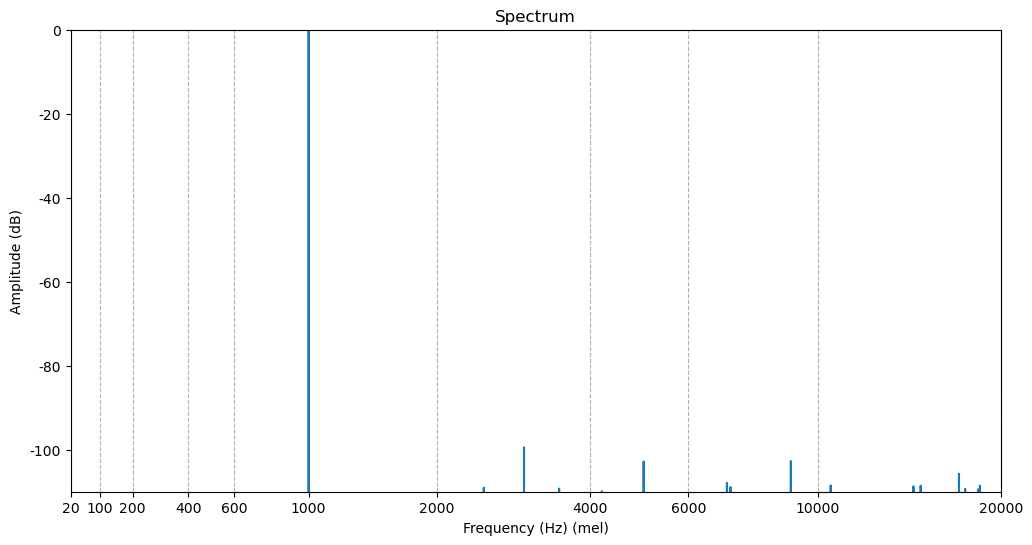

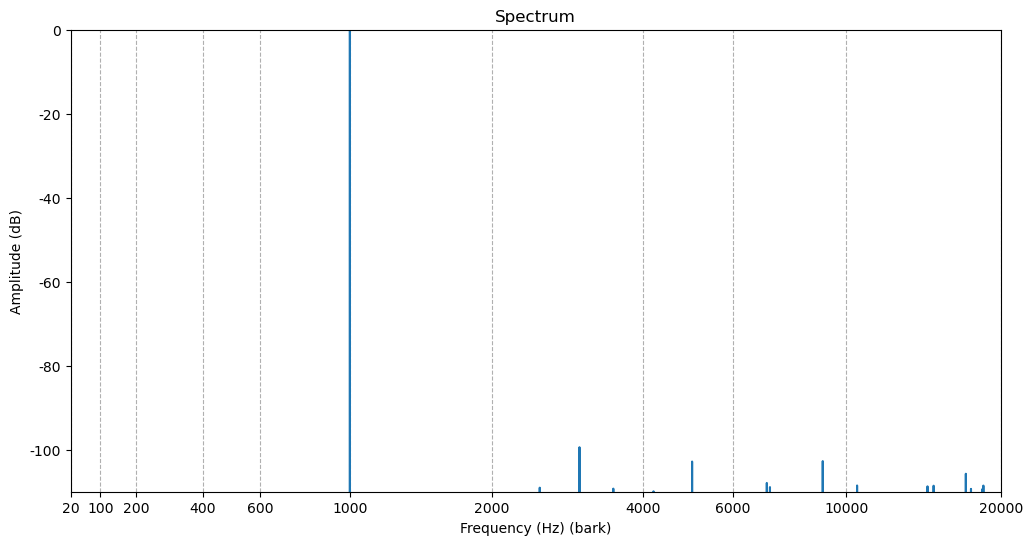

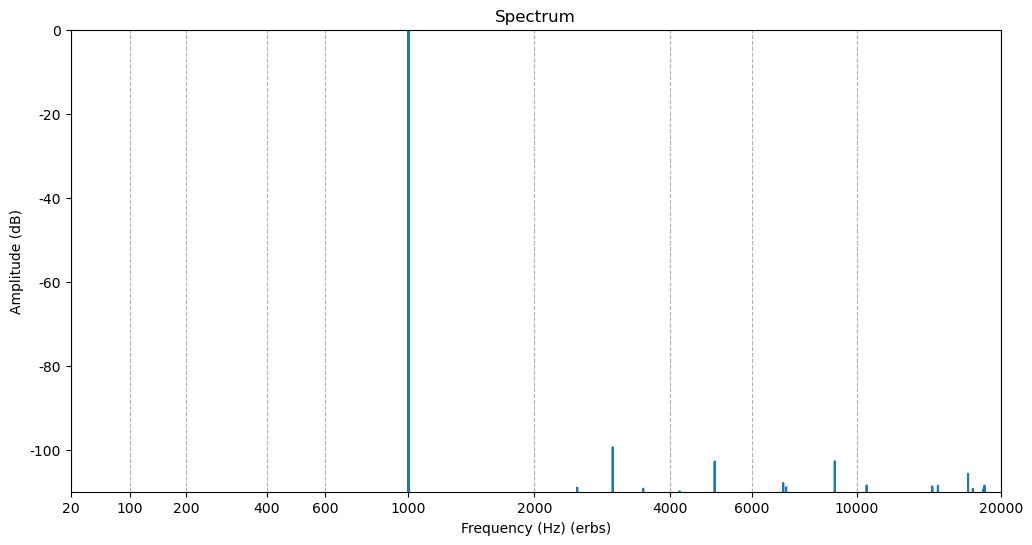

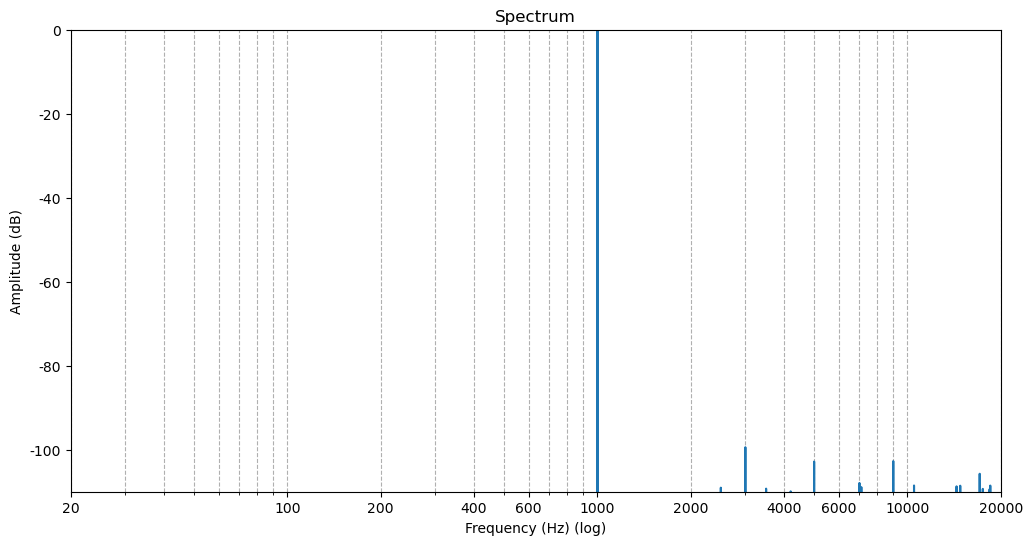

In [432]:
def generate_sine_wave(frequency, duration, sample_rate=44100, amplitude=0.5):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = amplitude * np.sin(2 * np.pi * frequency * t)
    waveform = np.int16(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

sine_wave = generate_sine_wave(1000, 1)
sine_wave.export("exports/sine_wave.wav", format="wav")
plot_fourier_transformation(sine_wave, scale='mel')
plot_fourier_transformation(sine_wave, scale='bark')
plot_fourier_transformation(sine_wave, scale='erbs')
plot_fourier_transformation(sine_wave, scale='log')
del sine_wave

#### Explerimenting with different waveforms

$[ \text{dB} = 20 \cdot \log_{10}(|X[k]|) ]$



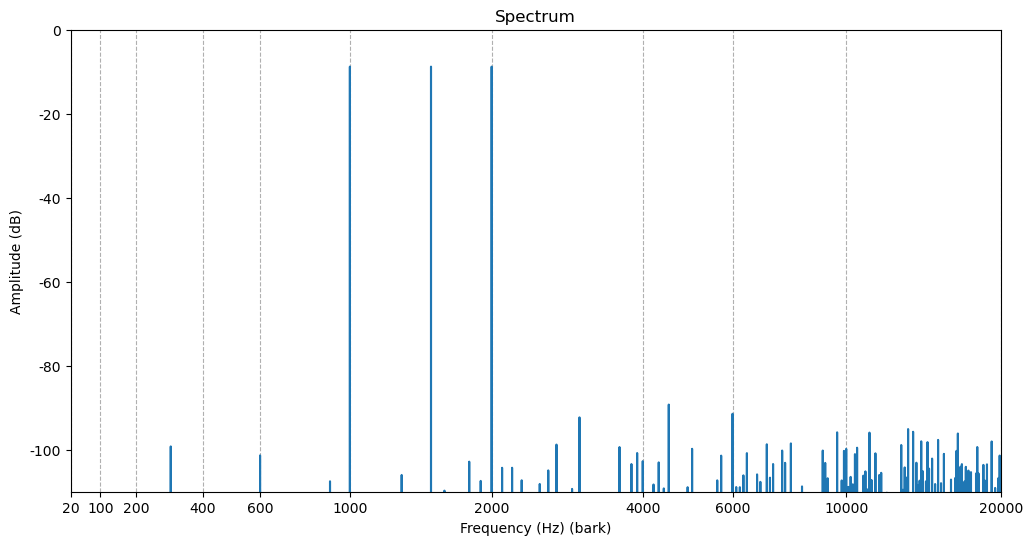

<_io.BufferedRandom name='exports/mixed_audio.wav'>

In [433]:
mixed_audio = generate_sine_wave(1000, 1, amplitude=0.1).overlay(generate_sine_wave(1500, 1, amplitude=0.1)).overlay(generate_sine_wave(2000, 1, amplitude=0.1))
#play(mixed_audio)
plot_fourier_transformation(mixed_audio)
mixed_audio.export("exports/mixed_audio.wav", format="wav")

This produces some noise but if we raise the bitraite that goes away:

Unfortunately soundcards arent easily set up for int32 bitrates. float32 is possible but complicated, and int24 is possible with soundcards but is complicated with numpy arrays. int16 has some noise but is the easiest to work with in this context.

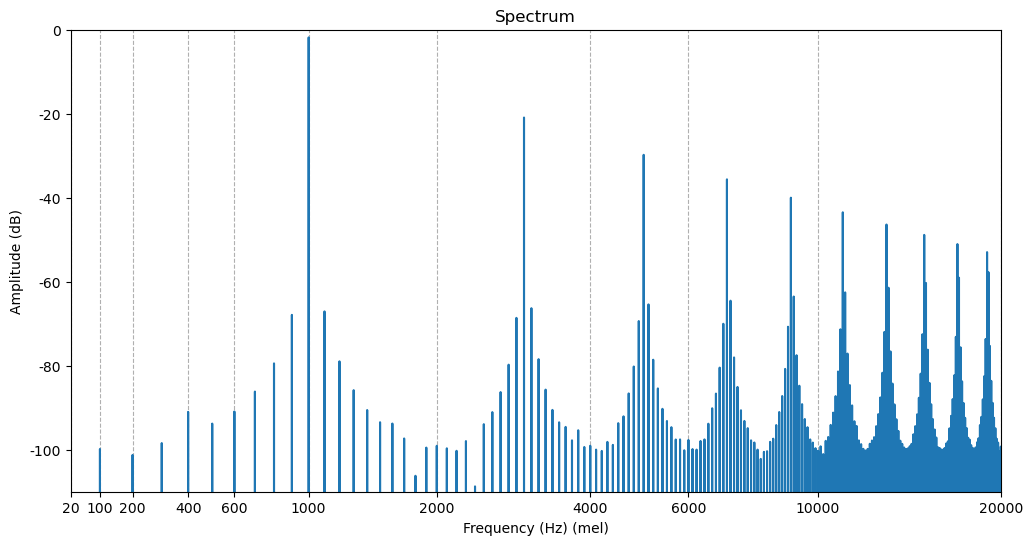

In [434]:
def generate_triangle_wave(frequency, duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate a triangle wave.

    Parameters:
    - frequency: Frequency of the triangle wave in Hz.
    - duration: Duration of the triangle wave in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the triangle wave (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated triangle wave as an AudioSegment object.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = 2 * amplitude * np.abs(2 * (t * frequency - np.floor(t * frequency + 0.5))) - amplitude
    if bitrate == 16:
        waveform = np.int16(waveform * 32767)
    if bitrate == 32:
        waveform = np.int32(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

# Example usage
triangle_wave = generate_triangle_wave(1000, 1)
#play(triangle_wave)
plot_fourier_transformation(triangle_wave, scale='mel')
triangle_wave.export("exports/triangle_wave.wav", format="wav")
del triangle_wave

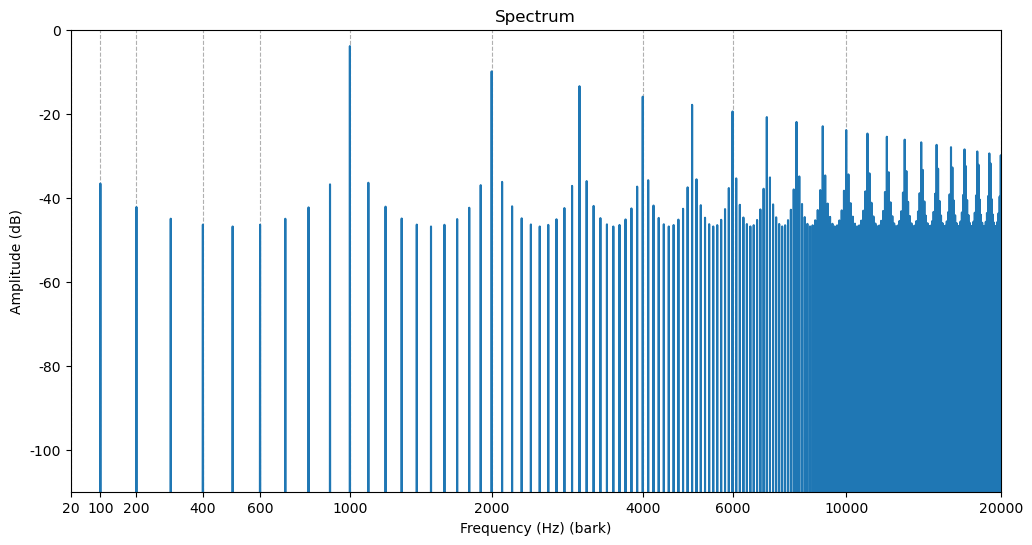

In [435]:
def generate_sawtooth_wave(frequency, duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate a sawtooth wave.

    Parameters:
    - frequency: Frequency of the sawtooth wave in Hz.
    - duration: Duration of the sawtooth wave in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the sawtooth wave (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated sawtooth wave as an AudioSegment object.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = 2 * amplitude * (t * frequency - np.floor(t * frequency + 0.5))
    if bitrate == 16:
        waveform = np.int16(waveform * 32767)
    if bitrate == 32:
        waveform = np.int32(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

# Example usage
sawtooth_wave = generate_sawtooth_wave(1000, 1)
#play(sawtooth_wave)
plot_fourier_transformation(sawtooth_wave)
del sawtooth_wave

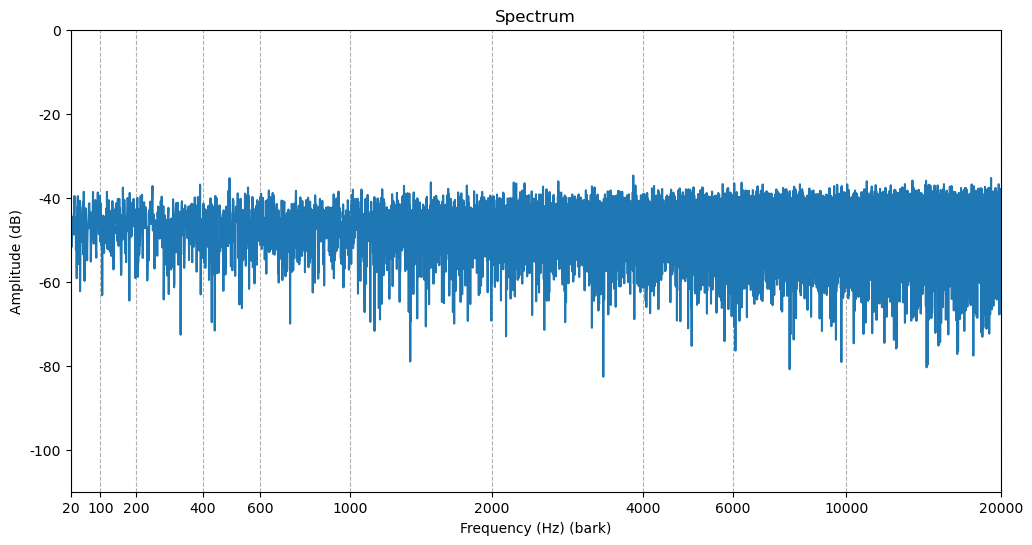

In [436]:
from pydub import AudioSegment
import numpy as np

def generate_white_noise(duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate white noise.

    Parameters:
    - duration: Duration of the white noise in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the white noise (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated white noise as an AudioSegment object.
    """
    # Generate random samples
    samples = np.random.uniform(low=-1.0, high=1.0, size=int(sample_rate * duration))
    if bitrate == 16:
        samples = (samples * amplitude * 32767).astype(np.int16)
    elif bitrate == 32:
        samples = (samples * amplitude * 32767).astype(np.int32)
    
    # Create an AudioSegment
    audio = AudioSegment(
        samples.tobytes(),
        frame_rate=sample_rate,
        sample_width=samples.dtype.itemsize,
        channels=1
    )
    
    return audio

# Example usage
white_noise = generate_white_noise(1, bitrate=16)  # 5 seconds of white noise
#play(white_noise)
plot_fourier_transformation(white_noise)

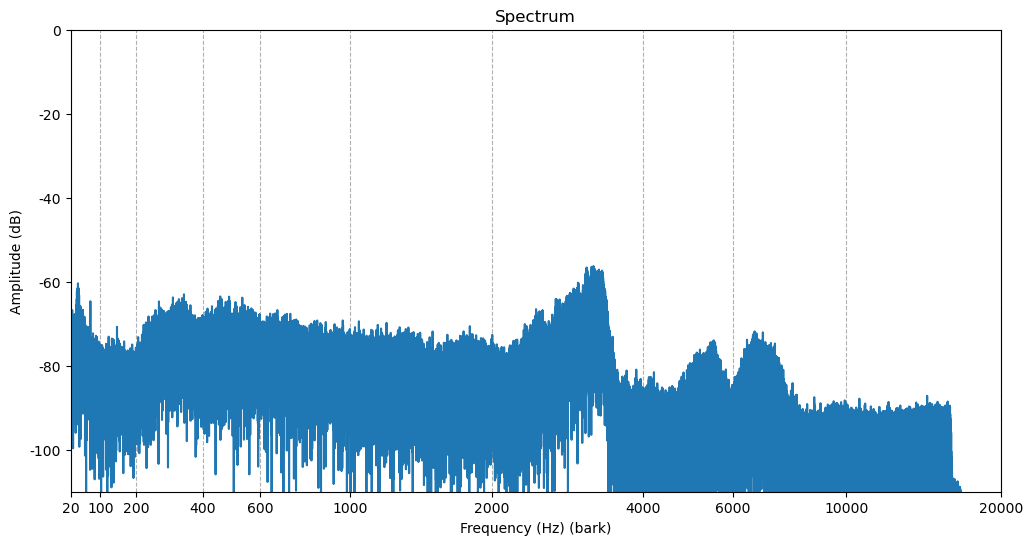

In [437]:
plot_fourier_transformation(bird_sound)

#### Reducing the number of datapoints

i literally cant fucking believe ive been able to just free ball this im so glad ive had the audio experiene ive had. lets make a function to simplify a foyer transformaion into a set of logorithmic results


In [438]:
def group_frequencies_rms(frequencies, freq_signal, scale='bark', min_freq=20, max_freq=20000, num_bins=100):
    freq_bins = None
    scale_function = None
    if scale == 'mel':
        scale_function = hz_to_mel
        inverse_scale_function = mel_to_hz
    if scale == 'bark':
        scale_function = hz_to_bark
        inverse_scale_function = bark_to_hz
    if scale == 'erbs':
        scale_function = hz_to_erbs
        inverse_scale_function = erbs_to_hz
    if scale == 'log':
        freq_bins = cp.logspace(cp.log10(min_freq), cp.log10(max_freq), num=num_bins)
        scale_function = lambda x, _: x
        inverse_scale_function = lambda x, _: x
    if freq_bins is None:
        freq_bins = cp.linspace(scale_function(min_freq), scale_function(max_freq), num=num_bins)
        freq_bins = inverse_scale_function(freq_bins)
    bin_indicies = cp.digitize(frequencies, freq_bins) - 1 
    rms_freq_signal = cp.zeros(len(freq_bins))
    for i in range(len(freq_bins)):
        bin_values = freq_signal[bin_indicies == i]
        rms_freq_signal[i] = -cp.sqrt(cp.mean(bin_values**2))
    return freq_bins, rms_freq_signal
        


In [439]:
def plot_fourier_transformation(sound, scale='bark'):
    frequencies, freq_signal = fourier_transform(sound)
    frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)
    plot_frequencies(frequencies, freq_signal, scale=scale)

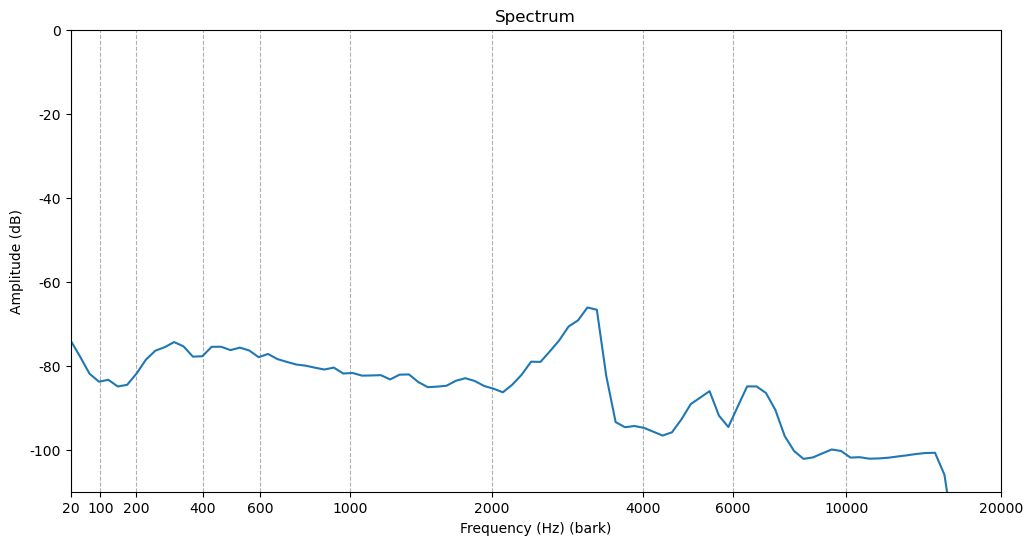

In [440]:
plot_fourier_transformation(bird_sound)

Seeing this brings me feelings of joy no one could possibly understand.

#### Fourier Transform Single Threaded Speed Tests.

Because of the long run times here, we are going to run some benchmarks on the different options we have avaliable to us in terms of performing fourier transformations. The FFT function exists both inside of the `numpy` library as well as the `scipy` library, and as well with access to a cuda capable GPU we can make use of a library called `cupy` that includes most of `numpy` and `scipy` but for running those processes on the GPU with the Cuda Toolkit. Luckly the Cuda Toolkit includes a builtin module for performing fourier transformations on the GPU built in so I have relatively high confidence this will be more performant than running on the CPU.

Micromamba should be able to take care of all of the install for `cupy` with the single command `micromamba install cupy`.

In [441]:
def file_array_size(file):
    return int(df[df.filename == file].array_size.values[0]*(df[df.filename == file].channel.max()+1))

def mono_file_array_size(file):
    return int(df[df.filename == file].array_size.values[0])

def cpu_normalize_signal(signal):
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    max_amplitude = np.max(np.abs(signal))
    return signal / max_amplitude

def cpu_magnitude_to_db(signal, epsilon=sys.float_info.epsilon):
    return 20 * np.log10(np.abs(signal) + epsilon)

def cpu_fourier_transform(sound, fft_module=np.fft):
    if sound.channels > 1:
        sound = sound.split_to_mono()[0]
    signal = cpu_normalize_signal(sound.get_array_of_samples())
    signal = fft_module.rfft(signal)
    n = int(sound.frame_count())
    signal = signal / (n/2)
    frequencies = fft_module.rfftfreq(n, 1/sound.frame_rate)
    return frequencies, cpu_magnitude_to_db(signal)

def get_audio(file):
    try:
        sound = AudioSegment.from_file(file, format=mediainfo(file)['format_name'])
        return file, sound
    except:
        print(f'Error loading {file}', end='\033[K')
        return file, None

async def decode_audio(file):
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, get_audio, file)

async def decode_bulk_audio(files):
    tasks = [decode_audio(file) for file in files]
    return await asyncio.gather(*tasks)
  
def df_generator(df):
    prev = None
    for file in df.filename.unique():
        prev = file
        if prev is None:
            continue
        yield prev, file_array_size(file)
    yield prev, None

In [442]:
async def benchmark_fft(iterations, size):
    if iterations * size > len(df):
        print("Not enough data to run the benchmark.")
        print("Try a smaller size or number of iterations.")
    numpy_times = []
    scipy_times = []
    cupy_times = []
    for i in range(iterations):
        test_df = df.sample(size)
        avalable_ram = 4 * 1024 ** 3  # 4 GB

        print()

        print_boundry('Starting NumPy Test')
        display_handler = None
        start_time = time.time()
        batch_size = 0
        processed_data = 0
        files = []
        generator = df_generator(test_df)
        while True:
            try:
                file, next_file_size = next(generator)
                files.append(file)
                batch_size += file_array_size(file)
                if next_file_size is None or batch_size + next_file_size > avalable_ram:
                    processed_batch_data = 0
                    for filename, sound in await decode_bulk_audio(files):
                        if sound is None:
                            print(f"Error loading sound for {filename}")
                            continue
                        sounds = sound.split_to_mono()
                        for channel in sounds:
                            _, _ = cpu_fourier_transform(channel)
                            processed_batch_data += mono_file_array_size(filename)
                        display_handler = print_progress_bar(processed_batch_data,
                                                             batch_size,
                                                             display_handler=display_handler,
                                                             message=f'{'/'.join(filename.split('/')[-2:])}',
                                                             convert_to_human_readable=True)
                        processed_data += file_array_size(filename)
                    batch_size = 0
                    files = []
            except StopIteration:
                break
        numpy_time = time.time() - start_time
        display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">Time to complete: {time_to_human_readable(numpy_time)} seconds - Processed Data: {bytes_to_human_readable(processed_data)}</pre>'))
        print_boundry('NumPy Test Complete')
        numpy_times.append(numpy_time)

        print()

        print_boundry('Starting SciPy Test')
        display_handler = None
        start_time = time.time()
        avalable_ram = 4 * 1024 ** 3  # 4 GB
        batch_size = 0
        processed_data = 0
        files = []
        generator = df_generator(test_df)
        while True:
            try:
                file, next_file_size = next(generator)
                files.append(file)
                batch_size += file_array_size(file)
                if next_file_size is None or batch_size + next_file_size > avalable_ram:
                    processed_batch_data = 0
                    for filename, sound in await decode_bulk_audio(files):
                        if sound is None:
                            print(f"Error loading sound for {filename}")
                            continue
                        sounds = sound.split_to_mono()
                        for channel in sounds:
                            _, _ = cpu_fourier_transform(channel, fft_module=sp.fft)
                            processed_batch_data += mono_file_array_size(filename)
                        display_handler = print_progress_bar(processed_batch_data,
                                                             batch_size,
                                                             display_handler=display_handler,
                                                             message=f'{'/'.join(filename.split('/')[-2:])}',
                                                             convert_to_human_readable=True)
                        processed_data += file_array_size(filename)
                    batch_size = 0
                    files = []
            except StopIteration:
                break
        scipy_time = time.time() - start_time
        display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">Time to complete: {time_to_human_readable(scipy_time)} seconds - Processed Data: {bytes_to_human_readable(processed_data)}</pre>'))
        print_boundry('SciPy Test Complete')
        scipy_times.append(scipy_time)

        print()

        print_boundry('Starting CuPy Test')
        display_handler = None
        start_time = time.time()
        avalable_ram = vram_pool.get_limit() * 0.90  # This is 90% of the 75% limit we set earlier.
        print(f'Available VRAM: {bytes_to_human_readable(avalable_ram)}')
        batch_size = 0
        processed_data = 0
        files = []
        generator = df_generator(test_df)
        while True:
            try:
                file, next_file_size = next(generator)
                files.append(file)
                batch_size += file_array_size(file)
                if next_file_size is None or batch_size + next_file_size > avalable_ram:
                    processed_batch_data = 0
                    for filename, sound in await decode_bulk_audio(files):
                        if sound is None:
                            print(f"Error loading sound for {filename}")
                            continue
                        sounds = sound.split_to_mono()
                        for channel in sounds:
                            _, _ = fourier_transform(channel)
                            processed_batch_data += mono_file_array_size(filename)
                        display_handler = print_progress_bar(processed_batch_data,
                                                             batch_size,
                                                             display_handler=display_handler,
                                                             message=f'{'/'.join(filename.split('/')[-2:])}',
                                                             convert_to_human_readable=True)
                        processed_data += file_array_size(filename)
                    vram_pool.free_all_blocks() # Free all blocks in the memory pool
                    batch_size = 0
                    files = []
            except StopIteration:
                break
        cupy_time = time.time() - start_time
        display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">Time to complete: {time_to_human_readable(cupy_time)} seconds - Processed Data: {bytes_to_human_readable(processed_data)}</pre>'))
        print_boundry('CuPy Test Complete')
        cupy_times.append(cupy_time)
        print_boundry(f'Iteration {i+1}/{iterations} Complete')
    return numpy_times, scipy_times, cupy_times


In [443]:
benchnmark_df = None
if os.path.exists('exports/i5_100x100_fft_benchmark.csv'):
    benchnmark_df = pd.read_csv('exports/i5_100x100_fft_benchmark.csv')
else:
    numpy_times, scipy_times, cupy_times = await benchmark_fft(100, 100)
    benchnmark_df = pd.DataFrame([numpy_times, scipy_times, cupy_times]).T
    benchnmark_df.columns = ['numpy', 'scipy', 'cupy']
benchnmark_df.to_csv('exports/i5_100x100_fft_benchmark.csv', index=False)

print(f'CuPy Average Time: {benchnmark_df['cupy'].mean():.2f} ± {benchnmark_df['cupy'].std():.2f}')
print(f'SciPy Average Time: {benchnmark_df['scipy'].mean():.2f} ± {benchnmark_df['scipy'].std():.2f}')
print(f'Numpy Average Time: {benchnmark_df['numpy'].mean():.2f} ± {benchnmark_df['numpy'].std():.2f}')
print()
print(f'SciPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['scipy'].mean():.2f}x')
print(f'CuPy Speedup Over SciPy: {benchnmark_df['scipy'].mean() / benchnmark_df['cupy'].mean():.2f}x')
print(f'CuPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['cupy'].mean():.2f}x')

CuPy Average Time: 15.57 ± 1.66
SciPy Average Time: 61.01 ± 11.11
Numpy Average Time: 64.12 ± 12.22

SciPy Speedup Over Numpy: 1.05x
CuPy Speedup Over SciPy: 3.92x
CuPy Speedup Over Numpy: 4.12x


In [444]:
benchnmark_df = None
if os.path.exists('exports/i5_10x2500_fft_benchmark.csv'):
    benchnmark_df = pd.read_csv('exports/i5_10x2500_fft_benchmark.csv')
else:
    numpy_times, scipy_times, cupy_times = await benchmark_fft(10, 2500)
    benchnmark_df = pd.DataFrame([numpy_times, scipy_times, cupy_times]).T
    benchnmark_df.columns = ['numpy', 'scipy', 'cupy']
benchnmark_df.to_csv('exports/i5_10x2500_fft_benchmark.csv', index=False)

print(f'CuPy Average Time: {benchnmark_df['cupy'].mean():.2f} ± {benchnmark_df['cupy'].std():.2f}')
print(f'SciPy Average Time: {benchnmark_df['scipy'].mean():.2f} ± {benchnmark_df['scipy'].std():.2f}')
print(f'Numpy Average Time: {benchnmark_df['numpy'].mean():.2f} ± {benchnmark_df['numpy'].std():.2f}')
print()
print(f'SciPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['scipy'].mean():.2f}x')
print(f'CuPy Speedup Over SciPy: {benchnmark_df['scipy'].mean() / benchnmark_df['cupy'].mean():.2f}x')
print(f'CuPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['cupy'].mean():.2f}x')

CuPy Average Time: 386.79 ± 12.30
SciPy Average Time: 1467.67 ± 51.19
Numpy Average Time: 1575.81 ± 55.87

SciPy Speedup Over Numpy: 1.07x
CuPy Speedup Over SciPy: 3.79x
CuPy Speedup Over Numpy: 4.07x


# Perform the Bulk Calculation.

In [445]:
# Add columns with the frequency bins
frequencies, freq_signal = fourier_transform(bird_sound)
frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)

# Create a dictionary to hold the new columns
new_columns = {f'{int(freq)}Hz': np.nan for freq in frequencies}

# Convert the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns, index=df.index)

# Concatenate the original DataFrame with the new columns DataFrame
df = pd.concat([df, new_columns_df], axis=1)

df.head()

rating ebird_code  channel        date  duration  \
0     3.5     aldfly        0  2013-05-25    25.488   
1     4.0     aldfly        0  2013-05-27    36.310   
2     4.0     aldfly        1  2013-05-27    36.310   
3     4.0     aldfly        0  2013-05-27    39.236   
4     4.0     aldfly        1  2013-05-27    39.236   

                                            filename latitude  sampling_rate  \
0  data/birdsong-recognition/train_audio/aldfly/X...   44.793          48000   
1  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   
2  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   
3  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   
4  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   

         type elevation  ... 13690Hz 14279Hz 14893Hz 15534Hz 16202Hz 16899Hz  \
0        call     220 m  ...     NaN     NaN     NaN     NaN     NaN     NaN   
1  call, song    1700 m  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2  call, song    1700 m  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3  call, song    1700 m  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4  call, song    1700 m  ...     NaN     NaN     NaN     NaN     NaN     NaN   

  17626Hz 18384Hz 19175Hz  20000Hz  
0     NaN     NaN     NaN      NaN  
1     NaN     NaN     NaN      NaN  
2     NaN     NaN     NaN      NaN  
3     NaN     NaN     NaN      NaN  
4     NaN     NaN     NaN      NaN  

[5 rows x 120 columns]

In [446]:
if not os.path.exists('exports/audio_features.csv'):
    print_boundry('Starting Audio Processing')
    display_handler = None
    start_time = time.time()
    avalable_ram = vram_pool.get_limit() * 0.90  # This is 90% of the 75% limit we set earlier.
    print(f'Available VRAM: {bytes_to_human_readable(avalable_ram)}')
    batch_size = 0
    processed_data = 0
    files = []
    generator = df_generator(df)
    while True:
        try:
            file, next_file_size = next(generator)
            files.append(file)
            batch_size += file_array_size(file)
            if next_file_size is None or batch_size + next_file_size > avalable_ram:
                processed_batch_data = 0
                for filename, sound in await decode_bulk_audio(files):
                    if sound is None:
                        print(f"Error loading sound for {filename}")
                        continue
                    sounds = sound.split_to_mono()
                    for i in range(sound.channels):
                        frequencies, freq_signal = fourier_transform(sounds[i])
                        frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)
                        frequencies, freq_signal = frequencies.get(), freq_signal.get()
                        for freq in frequencies:
                            df.loc[(df.filename == filename) & (df.channel == i), f'{int(freq)}Hz'] = freq_signal[frequencies == freq]
                        processed_batch_data += mono_file_array_size(filename)
                        display_handler = print_progress_bar(processed_batch_data,
                                                             batch_size,
                                                             display_handler=display_handler,
                                                             message=f'{'/'.join(filename.split('/')[-2:])}',
                                                             convert_to_human_readable=True)
                    processed_data += file_array_size(filename)
                vram_pool.free_all_blocks() # Free all blocks in the memory pool
                print(f'Batch Processed, Total Data Processed: {bytes_to_human_readable(processed_data)}/{bytes_to_human_readable(df["array_size"].sum())}')
                print('Estimated Time Remaining:', calculate_time_remaining(start_time, processed_data, df['array_size'].sum()))
                batch_size = 0
                files = []
        except StopIteration:
            break
    print_boundry('Audio Processing Complete')
    print(f'Processed Data: {bytes_to_human_readable(processed_data)}')
    df.to_csv('exports/audio_features.csv', index=False)
    del start_time, avalable_ram, batch_size, processed_data, files, generator, df
else:
    print('Loading audio features')
df = pd.read_csv('exports/audio_features.csv')
df.head()

Loading audio features


rating ebird_code  channel        date  duration  \
0     3.5     aldfly        0  2013-05-25    25.488   
1     4.0     aldfly        0  2013-05-27    36.310   
2     4.0     aldfly        1  2013-05-27    36.310   
3     4.0     aldfly        0  2013-05-27    39.236   
4     4.0     aldfly        1  2013-05-27    39.236   

                                            filename latitude  sampling_rate  \
0  data/birdsong-recognition/train_audio/aldfly/X...   44.793          48000   
1  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   
2  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   
3  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   
4  data/birdsong-recognition/train_audio/aldfly/X...  36.1065          44100   

         type elevation  ...     13690Hz     14279Hz     14893Hz     15534Hz  \
0        call     220 m  ... -114.740417 -115.474152 -115.668892 -116.013107   
1  call, song    1700 m  ... -102.042267 -101.842033 -101.859543 -123.234306   
2  call, song    1700 m  ... -102.506180 -102.306938 -102.324348 -123.694992   
3  call, song    1700 m  ... -104.452339 -104.657265 -104.633743 -125.490913   
4  call, song    1700 m  ... -104.733505 -104.938713 -104.913765 -125.801163   

      16202Hz     16899Hz     17626Hz     18384Hz     19175Hz     20000Hz  
0 -130.761688 -155.399460 -155.453079 -155.454254 -155.387192 -155.487930  
1 -150.910294 -151.103989 -151.018845 -151.072021 -151.050583 -151.064941  
2 -151.393143 -151.566650 -151.464447 -151.503632 -151.549072 -151.514771  
3 -154.434433 -154.565750 -154.511963 -154.542084 -154.482361 -154.525848  
4 -154.748199 -154.861481 -154.861603 -154.789734 -154.828293 -154.810211  

[5 rows x 120 columns]

## Verify the new dataset

In [447]:
# Find columns that end with 'Hz'
hz_columns = [col for col in df.columns if col.endswith('Hz')]

# Find rows where any of the 'Hz' columns contain null values
null_rows = df[df[hz_columns].isnull().any(axis=1)]

# Print the number of rows and the rows themselves
print(f'Number of rows with null values in Hz columns: {len(null_rows)}')
null_rows

Number of rows with null values in Hz columns: 408


rating ebird_code  channel        date  duration  \
111       4.0     aldfly        0  2016-05-28     6.276   
308       4.5     amecro        0  2015-02-11    18.338   
309       4.5     amecro        1  2015-02-11    18.338   
315       4.5     amecro        0  2015-02-13    15.185   
316       4.5     amecro        1  2015-02-13    15.185   
...       ...        ...      ...         ...       ...   
31104     4.5     yerwar        0  2018-06-15   103.996   
31105     4.5     yerwar        1  2018-06-15   103.996   
31146     2.5     yetvir        0  2013-06-16    51.644   
31179     3.0     yetvir        0  2015-04-07    27.533   
31217     3.0     yetvir        0  2017-01-23     9.117   

                                                filename latitude  \
111    data/birdsong-recognition/train_audio/aldfly/X...  44.8234   
308    data/birdsong-recognition/train_audio/amecro/X...  48.4175   
309    data/birdsong-recognition/train_audio/amecro/X...  48.4175   
315    data/birdsong-recognition/train_audio/amecro/X...  47.6551   
316    data/birdsong-recognition/train_audio/amecro/X...  47.6551   
...                                                  ...      ...   
31104  data/birdsong-recognition/train_audio/yerwar/X...  63.3479   
31105  data/birdsong-recognition/train_audio/yerwar/X...  63.3479   
31146  data/birdsong-recognition/train_audio/yetvir/X...  42.2136   
31179  data/birdsong-recognition/train_audio/yetvir/X...   38.287   
31217  data/birdsong-recognition/train_audio/yetvir/X...   -0.667   

       sampling_rate  type elevation  ... 13690Hz 14279Hz 14893Hz 15534Hz  \
111            16000  call      40 m  ...     NaN     NaN     NaN     NaN   
308            22050  call      10 m  ...     NaN     NaN     NaN     NaN   
309            22050  call      10 m  ...     NaN     NaN     NaN     NaN   
315            22050  call      10 m  ...     NaN     NaN     NaN     NaN   
316            22050  call      10 m  ...     NaN     NaN     NaN     NaN   
...              ...   ...       ...  ...     ...     ...     ...     ...   
31104          24000  song     900 m  ...     NaN     NaN     NaN     NaN   
31105          24000  song     900 m  ...     NaN     NaN     NaN     NaN   
31146          22050  song     120 m  ...     NaN     NaN     NaN     NaN   
31179          22050  song       2 m  ...     NaN     NaN     NaN     NaN   
31217          22050  song    1500 m  ...     NaN     NaN     NaN     NaN   

      16202Hz 16899Hz 17626Hz 18384Hz 19175Hz  20000Hz  
111       NaN     NaN     NaN     NaN     NaN      NaN  
308       NaN     NaN     NaN     NaN     NaN      NaN  
309       NaN     NaN     NaN     NaN     NaN      NaN  
315       NaN     NaN     NaN     NaN     NaN      NaN  
316       NaN     NaN     NaN     NaN     NaN      NaN  
...       ...     ...     ...     ...     ...      ...  
31104     NaN     NaN     NaN     NaN     NaN      NaN  
31105     NaN     NaN     NaN     NaN     NaN      NaN  
31146     NaN     NaN     NaN     NaN     NaN      NaN  
31179     NaN     NaN     NaN     NaN     NaN      NaN  
31217     NaN     NaN     NaN     NaN     NaN      NaN  

[408 rows x 120 columns]

This is more than I expected, though 412 problem rows in a list of 31 thousnad isnt a bad ratio.

In [448]:
#for index, row in null_rows.iterrows():
#    filename = row['filename']
#    print_boundry(f'Processing {filename}')
#    sound = AudioSegment.from_file(filename, format=mediainfo(filename)['format_name'])
#    sounds = sound.split_to_mono()
#    for i, channel in enumerate(sounds):
#        frequencies, freq_signal = fourier_transform(channel)
#        frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)
#        frequencies, freq_signal = frequencies.get(), freq_signal.get()
#        for freq in frequencies:
#            print('Original:', df.loc[(df.filename == filename) & (df.channel == i), f'{int(freq)}Hz'].values[0])
#            print('New:', freq_signal[frequencies == freq])
#            df.loc[(df.filename == filename) & (df.channel == i), f'{int(freq)}Hz'] = freq_signal[frequencies == freq]

for index, row in null_rows.iterrows():
    filename = row.filename
    print_boundry(f'Checking {filename}')
    print('Sample Rate:', row.sampling_rate)
    print('Nyquist Frequency:', row.sampling_rate / 2)

----------------- Checking data/birdsong-recognition/train_audio/aldfly/XC319017.mp3 -----------------
Sample Rate: 16000
Nyquist Frequency: 8000.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC233496.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC233496.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC289011.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC289011.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amekes/XC127418.mp3 -----------------
Sample Rate: 24000
Nyquist Frequency: 12000.0
----------------- Checking data/birdsong-recognition/train_audio/amekes/XC127418.mp3 -----------------
Samp

After trying to reperform the fourier transformations and not getting a different result, I analized one of the problem files with an audio editor and found the file had am abnormally low sample rate. If the sample rate is too low it is impossible to replicate high frequency sounds, the highest frequency possible in an audio file is exactly one half the sample rate, which would be equivelant to having one sample on each phase of the wave. All of my code normalizes the range to between 20Hz and 20kHz, but some files are not able to replicate some of those frequencies and result in NaN for those frequency bins. This makes me inclined too look at what sample rates we have.

In [449]:
print(df.sampling_rate.value_counts())

sampling_rate
44100    19554
48000    11317
22050      170
32000      100
24000       91
16000       37
11025        5
8000         2
Name: count, dtype: int64


This is actually a quite surprsing spread. 44.1kHz is the standard for most things like CD's, 48kHz is the standard for video. Most other sample rates I have seen are integer multiples of one of those two numbers, ie 96kHz, 88.2kH, ect. I have never seen files with sample rates like some of these, but they should still mostly be capable of producing enough information to be useful in some cases. A sample rate of 32kHz produces a Nyquist Frequency of 16kHz, and that should be enough information to be useful to the model. I expect many of the files with higher sample rates may already have many of the >16kHz frequencies "rolled off" by mp3 compression or as an intentional decision by an audio engineer to remove excess unhelpful noise.

The 24kHz and 22.05kHz files concern me more, with Nyquist frequencies closer to 10kHz. They may contain enough information to hear the birdcall, but they may confuse the model a little if we were to train off of them.

Anything below 20kHz feels like it cant be very useful to us. Too many frequencies would be unaccounted for.

I will set the 32kHz files to fill the NaN values with -150.0 (remember these bins are measured in decebels), and I will drop any row with a sample rate below 32kHz.

In [450]:
# Remove rows with a sampling rate below 32000
df = df[df.sampling_rate >= 32000]

# Fill null values in files with sample rate of 32000
for index, row in df[df.sampling_rate == 32000].iterrows():
    for col in hz_columns:
        # if the value is null, fill it with -150.0
        if pd.isnull(row[col]):
            df.loc[index, col] = -150.0

df[df.isnull().any(axis=1)]

rating ebird_code  channel        date  duration  \
6492      2.5     buwwar        1  2015-05-13   209.607   
6494      3.0     buwwar        1  2016-05-23   110.028   
21984     5.0     pinjay        1  2015-01-25    24.947   

                                                filename latitude  \
6492   data/birdsong-recognition/train_audio/buwwar/X...  40.9999   
6494   data/birdsong-recognition/train_audio/buwwar/X...  40.9999   
21984  data/birdsong-recognition/train_audio/pinjay/X...  37.8853   

       sampling_rate                                        type elevation  \
6492           44100                                  male, song     200 m   
6494           44100                                  male, song     200 m   
21984          44100  call, includes what I call "metalic" calls    2300 m   

       ... 13690Hz 14279Hz 14893Hz 15534Hz 16202Hz 16899Hz 17626Hz 18384Hz  \
6492   ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
6494   ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
21984  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      19175Hz  20000Hz  
6492      NaN      NaN  
6494      NaN      NaN  
21984     NaN      NaN  

[3 rows x 120 columns]

When looking at the remining weird files with an audio analysis tool, most of them are simply the result of a stereo file only containing one track of audio. `/buwwar/XC481834.mp3`, `/buwwar/XC481837.mp3`, and `/pinjay/XC215462.mp3` can all be removed because they actually contain no audio data.

In [451]:
df = df.dropna(subset=['20Hz'])
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [rating, ebird_code, channel, date, duration, filename, latitude, sampling_rate, type, elevation, file_type, longitude, time, common_name, sci_name, order, family, species_group, bit_depth, array_size, 20Hz, 45Hz, 70Hz, 96Hz, 121Hz, 147Hz, 173Hz, 200Hz, 227Hz, 254Hz, 281Hz, 310Hz, 338Hz, 368Hz, 398Hz, 428Hz, 460Hz, 492Hz, 525Hz, 559Hz, 594Hz, 630Hz, 667Hz, 706Hz, 745Hz, 786Hz, 829Hz, 873Hz, 918Hz, 965Hz, 1014Hz, 1064Hz, 1117Hz, 1171Hz, 1227Hz, 1286Hz, 1347Hz, 1410Hz, 1476Hz, 1544Hz, 1616Hz, 1690Hz, 1767Hz, 1847Hz, 1930Hz, 2017Hz, 2107Hz, 2202Hz, 2300Hz, 2402Hz, 2508Hz, 2619Hz, 2734Hz, 2855Hz, 2980Hz, 3111Hz, 3247Hz, 3389Hz, 3536Hz, 3691Hz, 3851Hz, 4019Hz, 4194Hz, 4376Hz, 4565Hz, 4763Hz, 4970Hz, 5185Hz, 5409Hz, 5643Hz, 5887Hz, 6141Hz, 6407Hz, 6683Hz, 6972Hz, 7273Hz, 7586Hz, 7913Hz, 8254Hz, 8610Hz, ...]
Index: []

[0 rows x 120 columns]

Everything should be working as expected now.

# Analysing the new data
The first thing I want is a function that displays x random fourier transofmations from a dataset to give a random sample of what these spectrograms look like.

In [452]:
def add_plot_to_matrix(ax, frequencies, freq_signal, scale='bark', title='Spectrum', xlabel='Frequency (Hz)', ylabel='Amplitude (dB)'):
    if not isinstance(frequencies, cp.ndarray):
        frequencies = cp.asarray(frequencies, dtype=cp.float32)
    xticks = cp.array([20, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])
    if cp.max(freq_signal) > 0:
        print('Amplitude values must be negative for dBFS')
        return
    if scale not in ['log', 'mel', 'bark', 'erbs']:
        print('Invalid scale')
        return
    ax.set_title(title)
    ax.set_xlabel(xlabel + f' ({scale})')
    ax.set_ylabel(ylabel)
    scale_function = None
    if scale == 'log':
        scale_function = lambda x: x
        ax.set_xscale('log')
    if scale == 'mel':
        scale_function = hz_to_mel
        ax.set_xscale('linear')
    if scale == 'bark':
        scale_function = hz_to_bark
        ax.set_xscale('linear')
    if scale == 'erbs':
        scale_function = hz_to_erbs
        ax.set_xscale('linear')
    ax.set_xlim(scale_function(20), scale_function(20000))
    ax.set_xticks(scale_function(xticks).get(), xticks.get())
    ax.set_ylim(-150, 0)
    ax.set_yticks([0, -20, -40, -60, -80, -100, -120, -140],
                  [0, -20, -40, -60, -80, -100, -120, -140])
    if isinstance(freq_signal, cp.ndarray):
        freq_signal = freq_signal.get()
    ax.plot(scale_function(frequencies).get(), freq_signal)
    ax.grid(True, which="both", axis='x', ls="--")
    

def plot_matrix(df, x_length=2, y_length=3, scale='bark'):
    df = df.sample(x_length * y_length)
    _, axes = plt.subplots(y_length, x_length, figsize=(x_length * 8, y_length * 4))
    for i in range(y_length):
        for j in range(x_length):
            row = df.iloc[i * x_length + j]
            frequencies = [int(column[:-2]) for column in row.index if column.endswith("Hz")]
            freq_signal = row[[f'{frequency}Hz' for frequency in frequencies]].values
            add_plot_to_matrix(axes[i, j], frequencies, freq_signal, scale=scale, title=f'{row.ebird_code}/{row.filename.split("/")[-1]}')
    plt.tight_layout()
    plt.show()

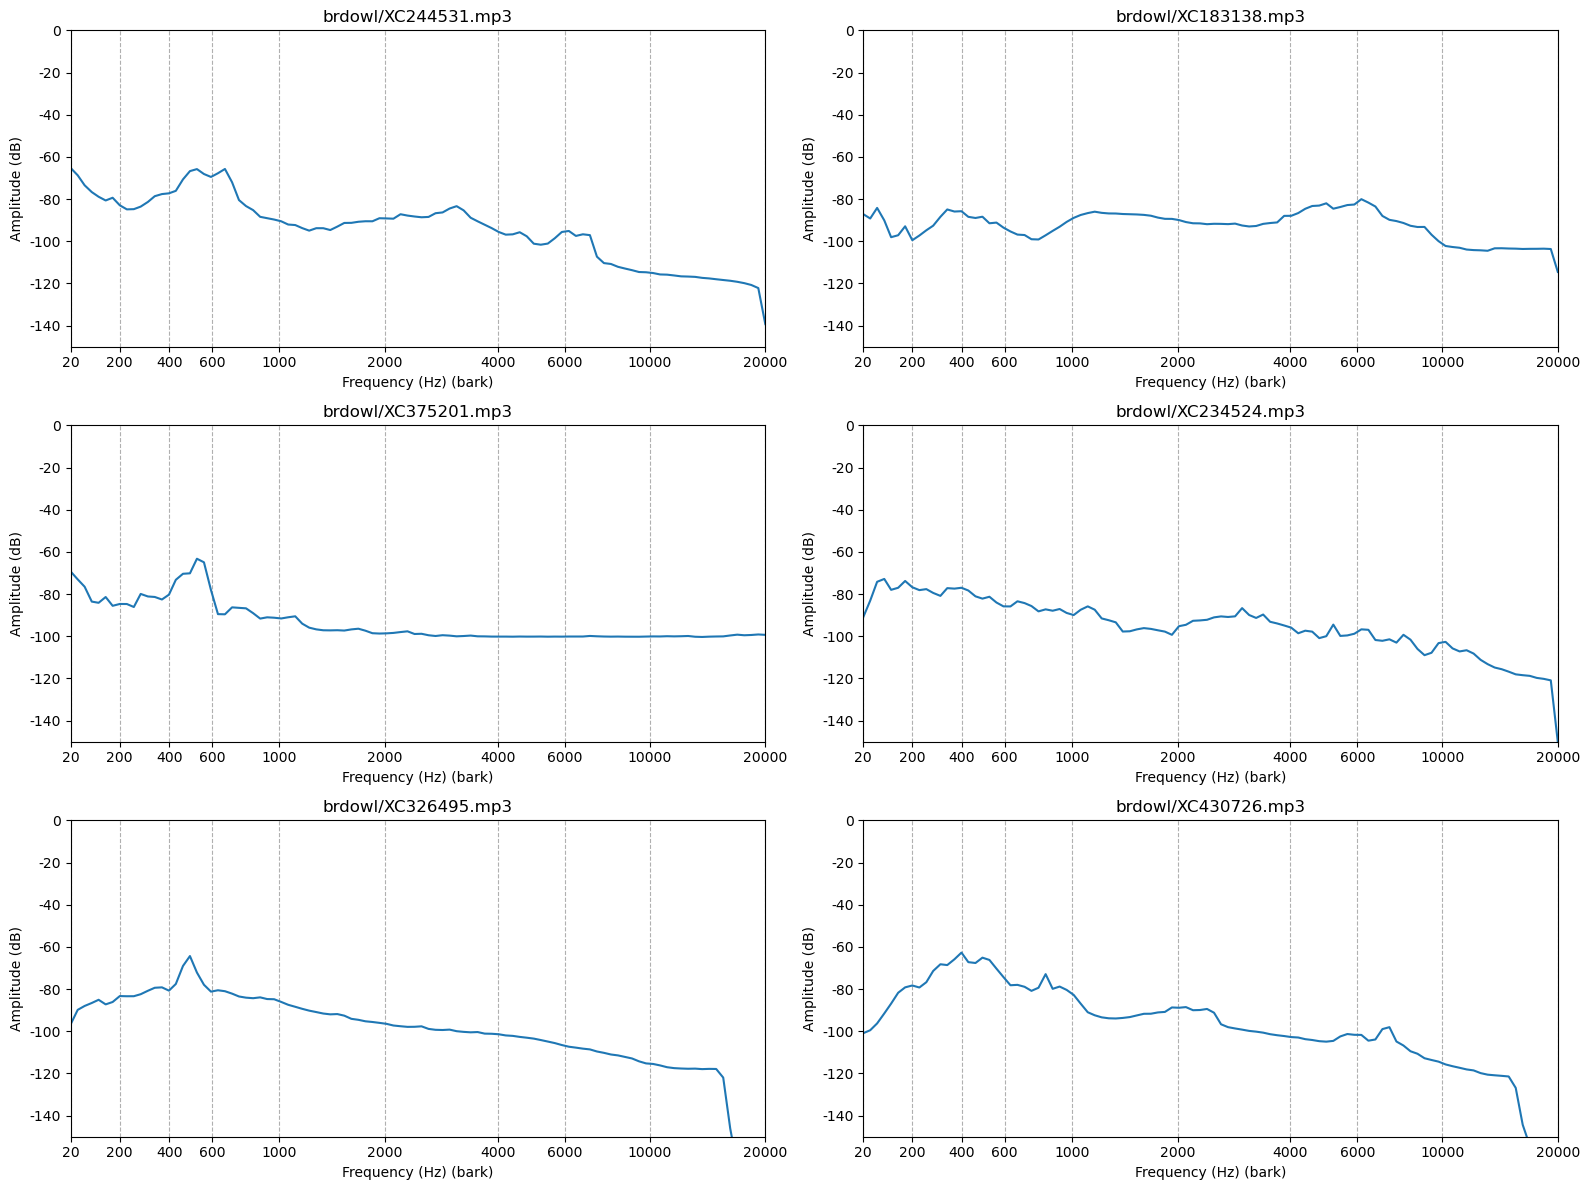

In [453]:
# Print plots for a Barred Owl.
plot_matrix(df[df.ebird_code == 'brdowl'])

## Now that that worked, lets take a look at our resulting dataset.

The first thing I want to make is a function that takes the dataframe and a column to analize. Inside the function the dataframe will be split by each unique value in the column listed, and each of those dataframes will then display a heatmap of the average values of the foyer transformations in the category. To start we will make a standalone function that will print the heatmap given a any dataframe, and we will test it by passing a dataframe with only `ebird_code == 'aldfly'`

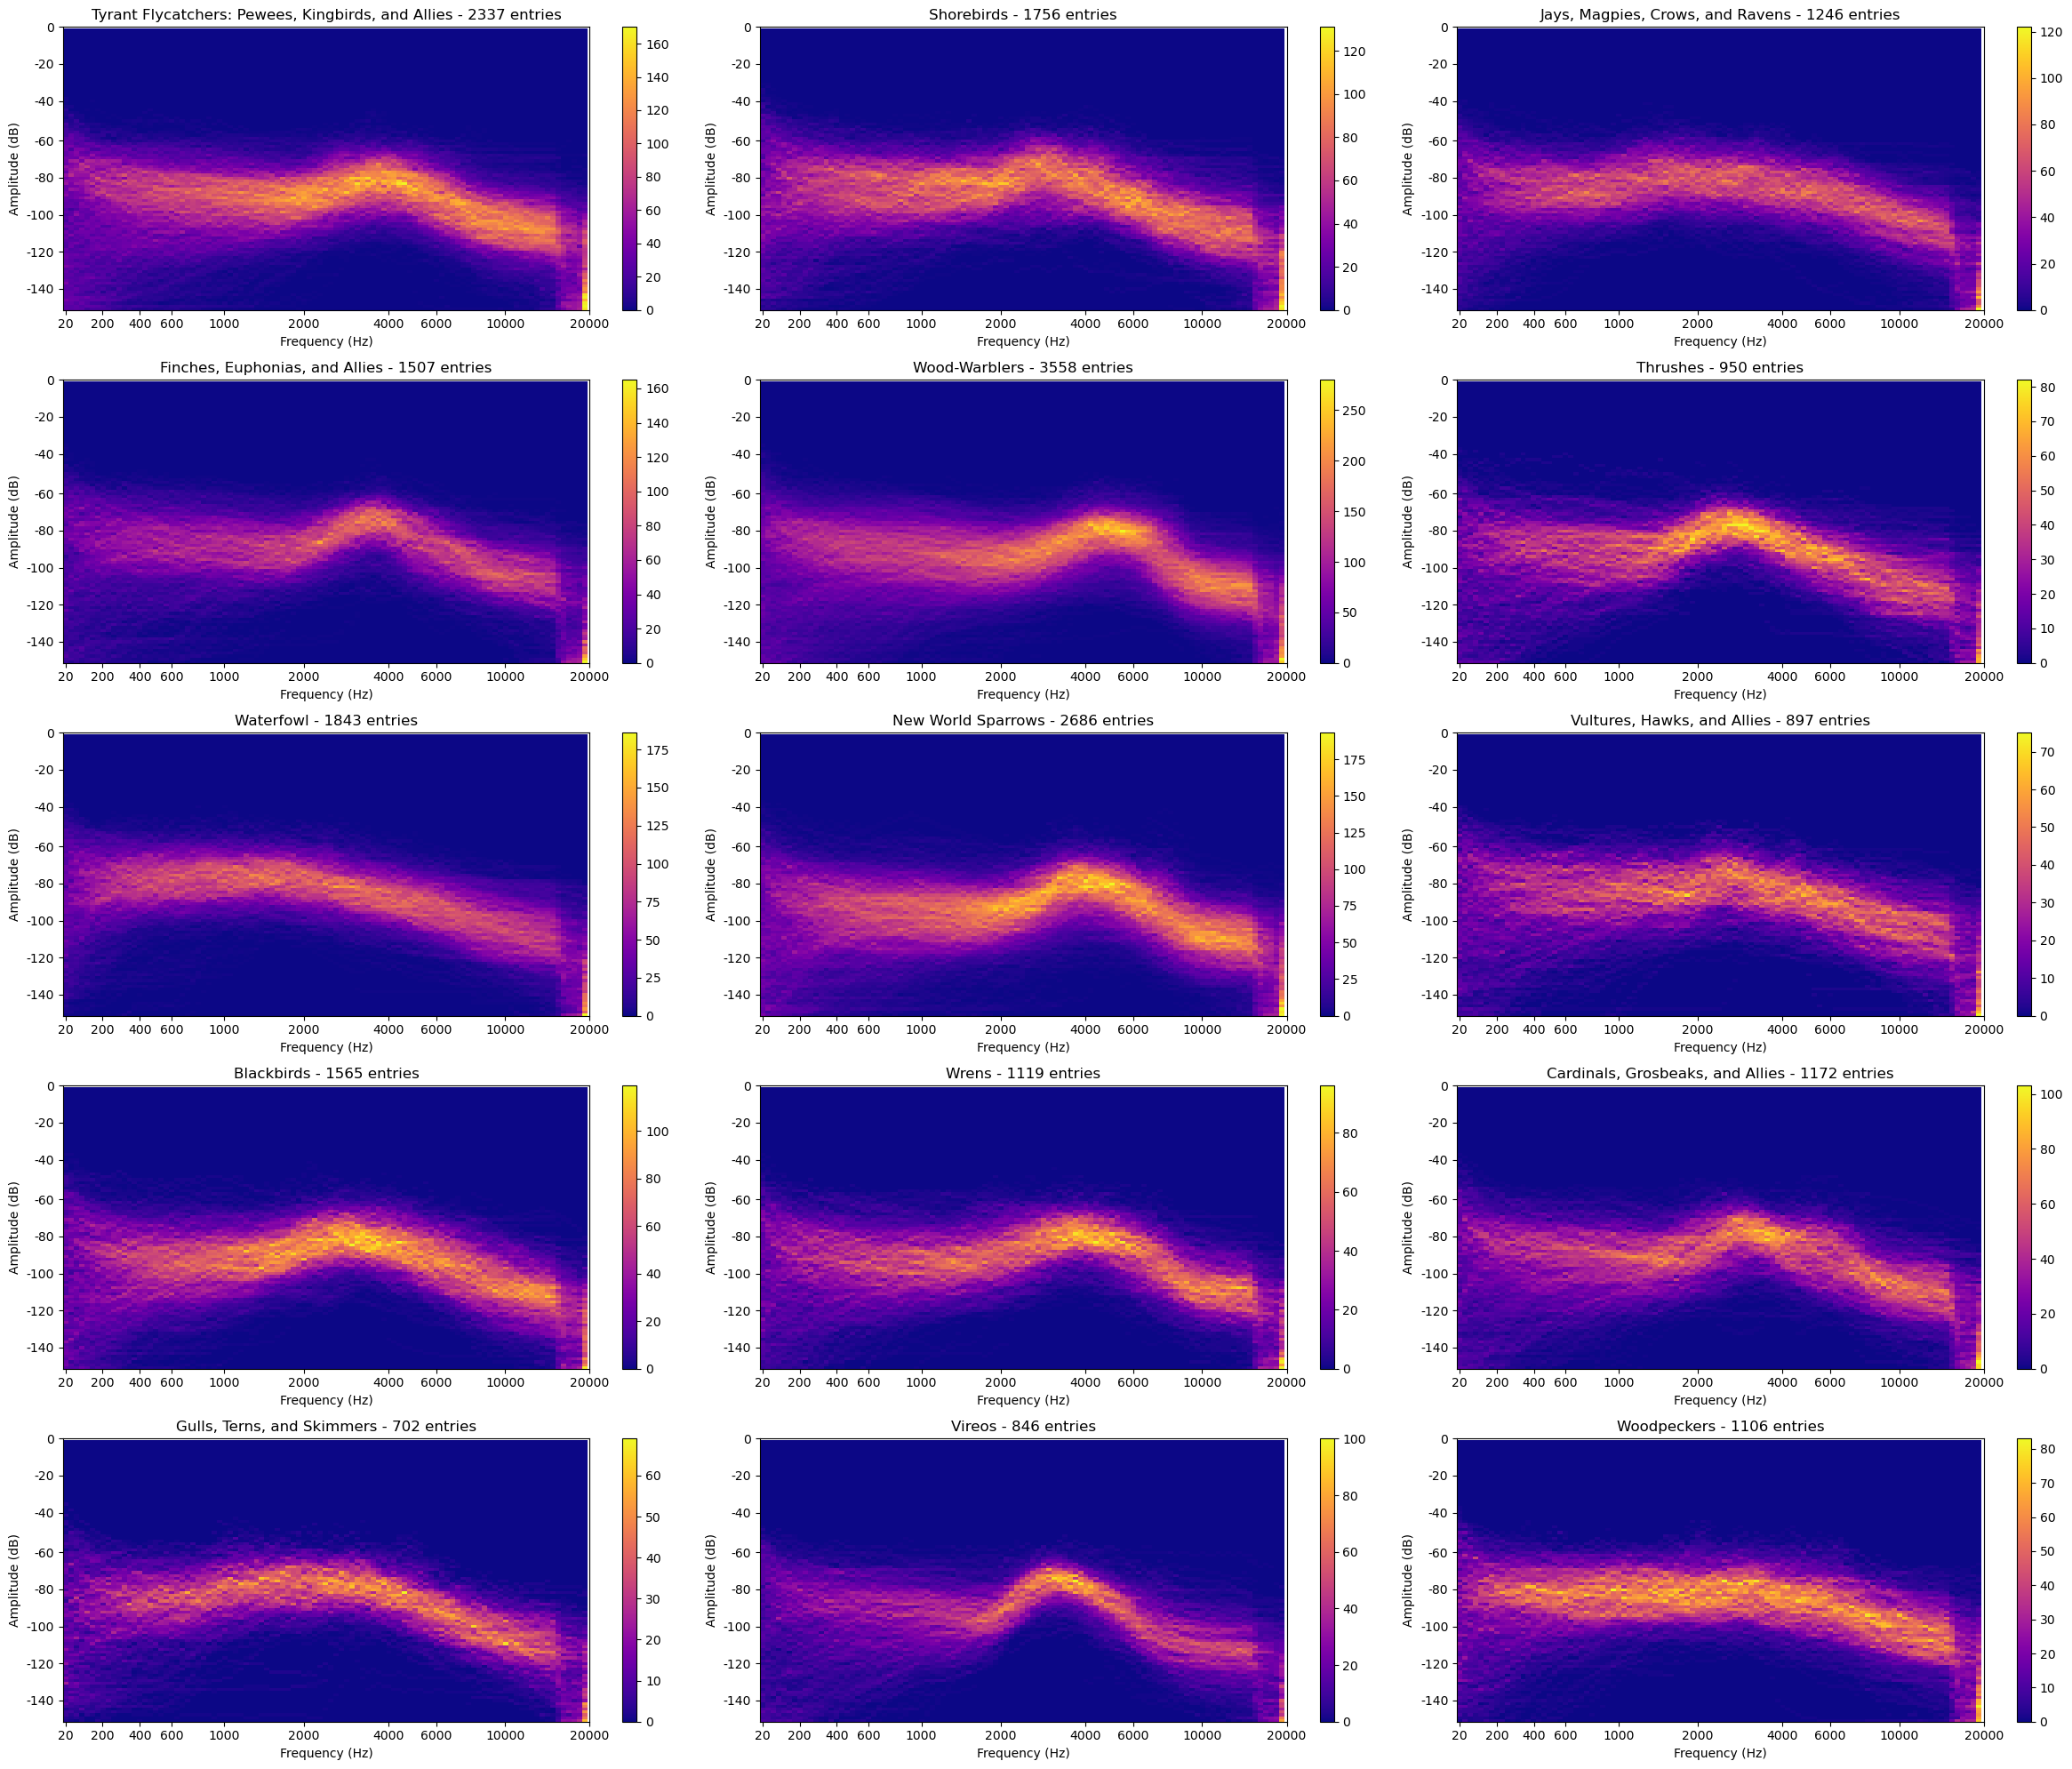

In [454]:
def plot_heatmap_matrix(df, x_length=3, column='ebird_code'):
    total_plots = len(df[column].unique())
    y_length = total_plots // x_length
    if total_plots % x_length != 0:
        y_length += 1
    fig, axes = plt.subplots(y_length, x_length, figsize=(x_length * 8, y_length * 4))
    axes = axes.flatten()
    for i, bird in enumerate(df[column].unique()):
        subset = df[df[column] == bird]
        x = []
        y = []
        for index, row in subset.iterrows():
            frequencies = [int(column[:-2]) for column in row.index if column.endswith("Hz")]
            freq_signal = row[[f'{frequency}Hz' for frequency in frequencies]].values
            x.append(frequencies)
            y.append(freq_signal)
        x = np.array(x)
        y = np.array(y)
        
        edge_x = np.unique(x)
        edge_y = np.linspace(-150, 0, 100)
        heatmap, edge_x, edge_y = np.histogram2d(x.flatten(), y.flatten(), bins=[edge_x, edge_y])

        xticks = np.array([20, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])
        yticks = np.array([0, -20, -40, -60, -80, -100, -120, -140])

        # get the index of the closest value to the xticks in the exdge_x array
        xtickvalues = np.abs(edge_x - xticks[:, np.newaxis]).argmin(axis=1)
        ytickvalues = np.abs(edge_y - yticks[:, np.newaxis]).argmin(axis=1)

        ax = axes[i]
        im = ax.imshow(heatmap.T, cmap='plasma', interpolation='nearest', origin='lower', aspect='auto')
        ax.set_title(f'{bird} - {len(subset)} entries')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude (dB)')
        ax.set_xticks(xtickvalues)
        ax.set_xticklabels(xticks)
        ax.set_yticks(ytickvalues)
        ax.set_yticklabels(yticks)
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# birds = ['aldfly', 'ameavo', 'amecro', 'amered', 'bkpwar', 'brdowl', 'cangoo', 'hergul']

# make a subset of df where only species_group contains at least 1000 entries
df_subset = df[df.species_group.isin(df.species_group.value_counts()[df.species_group.value_counts() > 700].index)]

plot_heatmap_matrix(df_subset, column='species_group')

play some files from the birds here to show what they sound like

# Convert other features

In [455]:
if not os.path.exists('exports/date_time_normalized.csv'):
    # drop rows with values that dont match the format '23:59'
    df = df[df.time.str.match(r'\d{2}:\d{2}')]

    # change date and time into a value between 0 and 1 where 0 is the year or day minimum and 1 is the year or day maximum
    for index, row in df.iterrows():
        # convert longitude, latitude, and elevation to float
        try:
            longitude = float(row.longitude)
        except:
            print(f'Error with {index}: {row.longitude}')
            df = df.drop(index)
            continue
        try:
            latitude = float(row.latitude)
        except:
            print(f'Error with {index}: {row.latitude}')
            df = df.drop(index)
            continue
        try:
            elevation = row.elevation
            if elevation[-3:] == 'm m':
                elevation = elevation[:-3]
            if elevation[-2:] == ' m':
                elevation = elevation[:-2]
            elevation = float(elevation)
        except:
            print(f'Error with {index}: {row.elevation}')
            df = df.drop(index)
            continue
        df.loc[index, 'longitude'] = longitude
        df.loc[index, 'latitude'] = latitude
        df.loc[index, 'elevation'] = elevation

        # convert time to a value between 0 and 1 where 0 is 00:00 and 1 is 23:59
        time = row.time
        time = time.split(':')
        if 'am' in time[1]:
            time[1] = time[1].replace('am', '')
        if 'pm' in time[1]:
            time[1] = time[1].replace('pm', '')
            time[0] = str(int(time[0]) + 12)
        time = int(time[0]) * 60 + int(time[1])
        time = time / (24 * 60)
        df.loc[index, 'time'] = time

        # convert date to a value between 0 and 1 where 0 is the minimum date and 1 is the maximum date
        date = row.date
        date = date.split('-')
        if int(date[1]) == 0:
            # drop the row
            print('-'.join(date))
            df = df.drop(index)
            continue
        date[0] = '2000'
        if int(date[2]) == 0:
            date[2] = '01'
        date = '-'.join(date)
        date = pd.to_datetime(date, format='%Y-%m-%d')
        date = date.dayofyear / 365
        df.loc[index, 'date'] = date
    df.to_csv('exports/date_time_normalized.csv', index=False)
else:
    print('Loading date and time normalized data')
df = pd.read_csv('exports/date_time_normalized.csv')
df

Loading date and time normalized data


rating ebird_code  channel      date  duration  \
0         4.0     aldfly        0  0.405479    36.310   
1         4.0     aldfly        1  0.405479    36.310   
2         4.0     aldfly        0  0.405479    39.236   
3         4.0     aldfly        1  0.405479    39.236   
4         3.5     aldfly        0  0.405479    33.593   
...       ...        ...      ...       ...       ...   
28815     4.5     yetvir        0  0.372603    28.659   
28816     3.5     yetvir        0  0.369863    52.704   
28817     5.0     yetvir        0  0.443836    96.072   
28818     3.5     yetvir        0  0.441096   103.576   
28819     3.5     yetvir        1  0.441096   103.576   

                                                filename  latitude  \
0      data/birdsong-recognition/train_audio/aldfly/X...   36.1065   
1      data/birdsong-recognition/train_audio/aldfly/X...   36.1065   
2      data/birdsong-recognition/train_audio/aldfly/X...   36.1065   
3      data/birdsong-recognition/train_audio/aldfly/X...   36.1065   
4      data/birdsong-recognition/train_audio/aldfly/X...   36.1065   
...                                                  ...       ...   
28815  data/birdsong-recognition/train_audio/yetvir/X...   39.5734   
28816  data/birdsong-recognition/train_audio/yetvir/X...   38.3619   
28817  data/birdsong-recognition/train_audio/yetvir/X...   38.3619   
28818  data/birdsong-recognition/train_audio/yetvir/X...   35.6878   
28819  data/birdsong-recognition/train_audio/yetvir/X...   35.6878   

       sampling_rate        type  elevation  ...     13690Hz     14279Hz  \
0              44100  call, song     1700.0  ... -102.042267 -101.842033   
1              44100  call, song     1700.0  ... -102.506180 -102.306938   
2              44100  call, song     1700.0  ... -104.452339 -104.657265   
3              44100  call, song     1700.0  ... -104.733505 -104.938713   
4              44100  call, song     1700.0  ... -104.014542 -103.948631   
...              ...         ...        ...  ...         ...         ...   
28815          48000        song      220.0  ... -103.881248 -106.552925   
28816          48000        song       50.0  ... -113.343094 -113.580788   
28817          48000        song       50.0  ... -121.665710 -121.870308   
28818          44100        song     1000.0  ... -111.218414 -111.333000   
28819          44100        song     1000.0  ... -111.679573 -111.793823   

          14893Hz     15534Hz     16202Hz     16899Hz     17626Hz     18384Hz  \
0     -101.859543 -123.234306 -150.910294 -151.103989 -151.018845 -151.072021   
1     -102.324348 -123.694992 -151.393143 -151.566650 -151.464447 -151.503632   
2     -104.633743 -125.490913 -154.434433 -154.565750 -154.511963 -154.542084   
3     -104.913765 -125.801163 -154.748199 -154.861481 -154.861603 -154.789734   
4     -103.954552 -125.273735 -153.715790 -153.864655 -153.841736 -153.886765   
...           ...         ...         ...         ...         ...         ...   
28815 -110.004036 -112.998917 -114.463112 -114.816315 -115.198486 -114.843170   
28816 -113.842903 -114.069626 -114.284286 -114.383759 -114.538895 -114.585312   
28817 -122.151375 -122.158707 -122.233780 -122.429398 -122.439064 -122.376846   
28818 -111.422157 -132.490845 -156.923416 -156.973724 -156.995758 -156.975937   
28819 -111.882339 -132.934296 -157.429825 -157.399628 -157.415024 -157.452896   

          19175Hz     20000Hz  
0     -151.050583 -151.064941  
1     -151.549072 -151.514771  
2     -154.482361 -154.525848  
3     -154.828293 -154.810211  
4     -153.879669 -153.868347  
...           ...         ...  
28815 -119.127151 -144.010651  
28816 -122.387360 -147.896652  
28817 -129.309586 -154.464600  
28818 -156.954712 -156.962952  
28819 -157.423111 -157.437973  

[28820 rows x 120 columns]

# Train a KNearestNeighbors model to classify birds from this data.

In [456]:
if os.path.exists('exports/mlpclassifier_results/full_frequency_range'):
    # Move everything in full_frequency to the mlpclassifier_results folder
    for folder in os.listdir('exports/mlpclassifier_results/full_frequency_range'):
        if folder == 'dt_classifier_benchmark.txt':
            os.rename(f'exports/mlpclassifier_results/full_frequency_range/{folder}', f'exports/{folder}')
            continue
        if not os.path.exists(f'exports/mlpclassifier_results/{folder}'):
            os.makedirs(f'exports/mlpclassifier_results/{folder}')
        for file in os.listdir(f'exports/mlpclassifier_results/full_frequency_range/{folder}'):
            os.rename(f'exports/mlpclassifier_results/full_frequency_range/{folder}/{file}', f'exports/mlpclassifier_results/{folder}/{file}')
        os.rmdir(f'exports/mlpclassifier_results/full_frequency_range/{folder}')
    os.rmdir('exports/mlpclassifier_results/full_frequency_range')

In [457]:
X = df.drop(columns=['rating', 'ebird_code', 'filename', 'channel', 'duration', 'sampling_rate', 'type', 'file_type', 'common_name', 'sci_name', 'order', 'family', 'species_group', 'bit_depth', 'array_size'])
y = df['species_group']


for column in X.columns:
    if column[-2:] == 'Hz':
        continue
    print(f'{column}:', X[column].dtype)
print(hz_columns)

date: float64
latitude: float64
elevation: float64
longitude: float64
time: float64
['20Hz', '45Hz', '70Hz', '96Hz', '121Hz', '147Hz', '173Hz', '200Hz', '227Hz', '254Hz', '281Hz', '310Hz', '338Hz', '368Hz', '398Hz', '428Hz', '460Hz', '492Hz', '525Hz', '559Hz', '594Hz', '630Hz', '667Hz', '706Hz', '745Hz', '786Hz', '829Hz', '873Hz', '918Hz', '965Hz', '1014Hz', '1064Hz', '1117Hz', '1171Hz', '1227Hz', '1286Hz', '1347Hz', '1410Hz', '1476Hz', '1544Hz', '1616Hz', '1690Hz', '1767Hz', '1847Hz', '1930Hz', '2017Hz', '2107Hz', '2202Hz', '2300Hz', '2402Hz', '2508Hz', '2619Hz', '2734Hz', '2855Hz', '2980Hz', '3111Hz', '3247Hz', '3389Hz', '3536Hz', '3691Hz', '3851Hz', '4019Hz', '4194Hz', '4376Hz', '4565Hz', '4763Hz', '4970Hz', '5185Hz', '5409Hz', '5643Hz', '5887Hz', '6141Hz', '6407Hz', '6683Hz', '6972Hz', '7273Hz', '7586Hz', '7913Hz', '8254Hz', '8610Hz', '8981Hz', '9368Hz', '9772Hz', '10193Hz', '10631Hz', '11089Hz', '11566Hz', '12064Hz', '12584Hz', '13125Hz', '13690Hz', '14279Hz', '14893Hz', '15534Hz'

In [458]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
  
knn = KNeighborsClassifier(n_neighbors=1)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=1 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=2)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=2 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=5)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=5 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=7)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=7 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=10)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=10 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')


n=1 Cross Validation Score: 57.59% ± 0.58%
n=2 Cross Validation Score: 41.67% ± 0.55%
n=5 Cross Validation Score: 33.19% ± 0.25%
n=7 Cross Validation Score: 32.93% ± 0.33%
n=10 Cross Validation Score: 32.60% ± 0.52%


In [459]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.60      0.55      0.57       307
                 Cardinals, Grosbeaks, and Allies       0.63      0.65      0.64       228
            Catbirds, Mockingbirds, and Thrashers       0.59      0.64      0.61        96
                          Cormorants and Anhingas       0.71      0.50      0.59        10
                                          Cuckoos       0.61      0.49      0.54        41
                            Falcons and Caracaras       0.68      0.59      0.63        61
                   Finches, Euphonias, and Allies       0.63      0.70      0.66       278
                                     Gnatcatchers       0.50      0.47      0.48        32
                                           Grebes       0.66      0.71      0.68        65
                        Grouse, Quail, and Allies       0.74      0.70      0.72        5

In [460]:
if not os.path.exists('exports/dt_classifier_benchmark.txt'):
    with open('exports/dt_classifier_benchmark.txt', 'w') as file:
        dt = DecisionTreeClassifier(max_depth=5)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 5 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=10)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 10 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=25)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 25 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=50)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 50 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=100)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 100 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=250)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 250 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)
else:
    with open('exports/dt_classifier_benchmark.txt', 'r') as file:
        for line in file:
            print(line.strip())

Decision Tree 5 Cross Validation Score: 20.04% ± 0.51%
Decision Tree 10 Cross Validation Score: 27.53% ± 0.31%
Decision Tree 25 Cross Validation Score: 42.23% ± 0.40%
Decision Tree 50 Cross Validation Score: 43.43% ± 0.47%
Decision Tree 100 Cross Validation Score: 43.53% ± 0.40%
Decision Tree 250 Cross Validation Score: 43.17% ± 0.68%


In [461]:
dt = DecisionTreeClassifier(max_depth=105)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.47      0.42      0.44       307
                 Cardinals, Grosbeaks, and Allies       0.43      0.41      0.42       228
            Catbirds, Mockingbirds, and Thrashers       0.41      0.48      0.44        96
                          Cormorants and Anhingas       0.25      0.20      0.22        10
                                          Cuckoos       0.43      0.32      0.37        41
                            Falcons and Caracaras       0.35      0.39      0.37        61
                   Finches, Euphonias, and Allies       0.46      0.50      0.48       278
                                     Gnatcatchers       0.42      0.41      0.41        32
                                           Grebes       0.45      0.45      0.45        65
                        Grouse, Quail, and Allies       0.41      0.42      0.42        5

# Lets Hijack the standard output so that we can predict how long the training will take

In [462]:
def test_iterator(iterations=100):
    for i in range(iterations):
        time.sleep(0.1)
        print(f'Iteration {i + 1}, loss = {np.random.uniform(0, 1):.4f}', flush=True)

In [463]:
class MLPTrainingMonitor:
    def __init__(self):
        self.start_time = None
        self.max_iterations = 0
        self.iteration = 0
        self.loss = 0
        self.learning_rate = 0
        self.min_loss = 10000
        self.iterations_since_minimum = 0
        self.display_handler = None
        pass

    def flush(self):
        pass

    def write(self, text):
        if 'SETUP:' in text:
            self.__init__()
            self.start_time = time.time()
            self.max_iterations = int(text.split(' ')[1].strip())
            self.learning_rate = float(text.split(' ')[2].strip())
            return

        elif 'FINISH:' in text:
            time_taken = time.time() - self.start_time
            final_iteration = self.iteration
            message = f'Loss: {self.loss:.6f}'
            message += f' - Min Loss: {self.min_loss:.6f}'
            message += f' - Final Iteration: {final_iteration}'
            message += f' - Learning Rate: {self.learning_rate}'
            message += f' - Time to complete: {time_to_human_readable(time_taken)}'
            self.display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">{message}</pre>'))
            path = text.split(' ')[1].strip()
            columns = ['loss', 'min_loss', 'final_iteration', 'learning_rate', 'time_taken']
            data = [[self.loss, self.min_loss, final_iteration, self.learning_rate, time_taken]]
            df = pd.DataFrame(data, columns=columns)
            path += '/training_monitor.csv'
            df.to_csv(path, index=False)
            return

        elif 'DISPLAY:' in text:
            df = pd.read_csv(text.split(' ')[1].strip() + '/training_monitor.csv')
            self.loss = df.loss.values[0]
            self.min_loss = df.min_loss.values[0]
            final_iteration = df.final_iteration.values[0]
            self.learning_rate = df.learning_rate.values[0]
            time_taken = df.time_taken.values[0]
            message = f'Loss: {self.loss:.6f}'
            message += f' - Min Loss: {self.min_loss:.6f}'
            message += f' - Final Iteration: {final_iteration}'
            message += f' - Learning Rate: {self.learning_rate}'
            message += f' - Time to complete: {time_to_human_readable(time_taken)}'
            if self.display_handler is None:
                self.display_handler = display(HTML(f'<pre style="font-family: monospace; font-size: 13px;">{message}</pre>'))
            else:
                self.display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">{message}</pre>'))
            return

        elif 'Iteration' in text:
            self.iteration = int(text.split(' ')[1][:-1])
            self.loss = float(text.split('loss =')[1].strip())
            if self.min_loss > self.loss:
                self.min_loss = self.loss
                self.iterations_since_minimum = 0
            else:
                self.iterations_since_minimum += 1

        elif 'learning rate' in text:
            self.learning_rate = float(text.split('Setting learning rate to ')[1].strip())

        else:
            return
        message = f'\nLoss: {self.loss:.6f}'
        message += f' - Min Loss: {self.min_loss:.6f}'
        message += f' - Iterations Since Minimum: {self.iterations_since_minimum}'
        message += f' - Learning Rate: {self.learning_rate:.6f}'
        message += f' - Estimated Time Remaining: {calculate_time_remaining(self.start_time, self.iteration, self.max_iterations)}'
        self.display_handler = print_progress_bar(self.iteration, 
                                                  self.max_iterations,
                                                  display_handler=self.display_handler,
                                                  message=message)

from contextlib import contextmanager

def setup_training(max_iterations, learning_rate):
    print(f'SETUP: {max_iterations} {learning_rate}')

def end_training(path):
    print(f'FINISH: {path}')


@contextmanager
def replace_stdout(new_stdout):
    original_stdout = sys.stdout
    sys.stdout = new_stdout
    try:
        yield
    finally:
        sys.stdout = original_stdout


def print_mlp_results(path):
    if not os.path.exists(path):
        print(f'File {path} does not exist.')
        return
    with replace_stdout(MLPTrainingMonitor()):
        print(f'DISPLAY: {path}')
    with open(path + '/classification_report.txt', 'r') as file:
        print(file.read())

In [464]:
# Use the context manager to replace sys.stdout temporarily
with replace_stdout(MLPTrainingMonitor()):
    setup_training(100, 0.001)
    test_iterator()



# now  we can apply that to an actually training session

In [465]:
print(f'Input Layer: {X_train.shape[1]}')
print(f'Output Layer: {len(y.unique())}')

Input Layer: 105
Output Layer: 45


# Series of models

In [466]:
def train_neural_network(max_iterations, learning_rate, hidden_layers):
    if not os.path.exists('exports/mlpclassifier_results'):
        os.makedirs('exports/mlpclassifier_results')
    path = f'exports/mlpclassifier_results/{"-".join(map(str, hidden_layers))}_{max_iterations}_{learning_rate}'
    if not os.path.exists(path):
        os.makedirs(path)
        nn = MLPClassifier(max_iter=max_iterations,
                           solver='sgd',
                           early_stopping=False,
                           verbose=True,
                           hidden_layer_sizes=hidden_layers,
                           learning_rate_init=learning_rate,
                           learning_rate='adaptive',
                           tol=0, alpha=0, beta_1=0, beta_2=0)

        with replace_stdout(MLPTrainingMonitor()):
            setup_training(max_iterations, learning_rate)
            nn.fit(X_train, y_train)
            end_training(path)

        y_pred = nn.predict(X_test)
        report = classification_report(y_test, y_pred)
        with open(f'{path}/classification_report.txt', 'w') as f:
            f.write(report)
        print(report)
    else:
        print_mlp_results(path)

In [467]:
train_neural_network(800, 0.01, [50, 10])
train_neural_network(700, 0.05, [50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.21      0.24      0.22       283
                 Cardinals, Grosbeaks, and Allies       0.32      0.19      0.23       232
            Catbirds, Mockingbirds, and Thrashers       0.38      0.31      0.34        88
                          Cormorants and Anhingas       0.00      0.00      0.00        10
                                          Cuckoos       0.07      0.03      0.04        32
                            Falcons and Caracaras       0.10      0.01      0.02        71
                   Finches, Euphonias, and Allies       0.33      0.40      0.36       279
                                     Gnatcatchers       0.15      0.07      0.10        28
                                           Grebes       0.00      0.00      0.00        61
                        Grouse, Quail, and Allies       0.35      0.12      0.18        5

In [468]:
train_neural_network(1000, 0.01, [500, 50])
train_neural_network(1000, 0.05, [500, 50])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.52      0.48      0.50       283
                 Cardinals, Grosbeaks, and Allies       0.53      0.50      0.51       232
            Catbirds, Mockingbirds, and Thrashers       0.45      0.57      0.50        88
                          Cormorants and Anhingas       0.67      0.20      0.31        10
                                          Cuckoos       0.68      0.47      0.56        32
                            Falcons and Caracaras       0.64      0.48      0.55        71
                   Finches, Euphonias, and Allies       0.54      0.59      0.57       279
                                     Gnatcatchers       0.55      0.64      0.59        28
                                           Grebes       0.62      0.34      0.44        61
                        Grouse, Quail, and Allies       0.56      0.53      0.55        5

In [469]:
train_neural_network(2500, 0.005, [1000, 100])
train_neural_network(1000, 0.01, [1000, 100])
train_neural_network(1000, 0.05, [1000, 100])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.56      0.60      0.58       307
                 Cardinals, Grosbeaks, and Allies       0.63      0.63      0.63       227
            Catbirds, Mockingbirds, and Thrashers       0.69      0.74      0.72        90
                          Cormorants and Anhingas       0.22      0.40      0.29         5
                                          Cuckoos       0.57      0.57      0.57        30
                            Falcons and Caracaras       0.65      0.61      0.63        57
                   Finches, Euphonias, and Allies       0.68      0.68      0.68       285
                                     Gnatcatchers       0.54      0.52      0.53        29
                                           Grebes       0.67      0.66      0.67        50
                        Grouse, Quail, and Allies       0.72      0.65      0.68        4

In [470]:
train_neural_network(3000, 0.005, [5000, 100])
train_neural_network(2000, 0.01, [5000, 100])
train_neural_network(1000, 0.05, [5000, 100])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.62      0.63      0.62       307
                 Cardinals, Grosbeaks, and Allies       0.67      0.64      0.66       227
            Catbirds, Mockingbirds, and Thrashers       0.64      0.76      0.69        90
                          Cormorants and Anhingas       0.25      0.40      0.31         5
                                          Cuckoos       0.56      0.63      0.59        30
                            Falcons and Caracaras       0.79      0.65      0.71        57
                   Finches, Euphonias, and Allies       0.73      0.72      0.73       285
                                     Gnatcatchers       0.71      0.76      0.73        29
                                           Grebes       0.64      0.74      0.69        50
                        Grouse, Quail, and Allies       0.72      0.58      0.64        4

In [471]:
train_neural_network(1200, 0.005, [100, 50, 10])
train_neural_network(1000, 0.01, [100, 50, 10])
train_neural_network(1000, 0.05, [100, 50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.22      0.24      0.23       287
                 Cardinals, Grosbeaks, and Allies       0.27      0.14      0.18       228
            Catbirds, Mockingbirds, and Thrashers       0.43      0.21      0.28        99
                          Cormorants and Anhingas       0.00      0.00      0.00         9
                                          Cuckoos       0.65      0.27      0.38        49
                            Falcons and Caracaras       0.24      0.06      0.10        62
                   Finches, Euphonias, and Allies       0.43      0.47      0.45       282
                                     Gnatcatchers       0.15      0.17      0.16        18
                                           Grebes       0.17      0.02      0.04        48
                        Grouse, Quail, and Allies       0.28      0.11      0.16        4

In [472]:
train_neural_network(5000, 0.005, [500, 50, 10])
train_neural_network(1000, 0.01, [500, 50, 10])
train_neural_network(1000, 0.05, [500, 50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.46      0.48      0.47       287
                 Cardinals, Grosbeaks, and Allies       0.51      0.50      0.51       228
            Catbirds, Mockingbirds, and Thrashers       0.56      0.55      0.55        99
                          Cormorants and Anhingas       0.33      0.11      0.17         9
                                          Cuckoos       0.43      0.31      0.36        49
                            Falcons and Caracaras       0.67      0.53      0.59        62
                   Finches, Euphonias, and Allies       0.51      0.61      0.56       282
                                     Gnatcatchers       0.28      0.44      0.34        18
                                           Grebes       0.39      0.38      0.38        48
                        Grouse, Quail, and Allies       0.35      0.46      0.40        4

In [473]:
train_neural_network(5000, 0.001, [1000, 100, 10])
train_neural_network(5000, 0.005, [1000, 100, 10])
train_neural_network(1000, 0.01, [1000, 100, 10])
train_neural_network(1000, 0.05, [1000, 100, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.24      0.27      0.26       287
                 Cardinals, Grosbeaks, and Allies       0.31      0.19      0.24       228
            Catbirds, Mockingbirds, and Thrashers       0.41      0.21      0.28        99
                          Cormorants and Anhingas       0.00      0.00      0.00         9
                                          Cuckoos       0.55      0.12      0.20        49
                            Falcons and Caracaras       0.33      0.06      0.11        62
                   Finches, Euphonias, and Allies       0.43      0.51      0.47       282
                                     Gnatcatchers       0.20      0.06      0.09        18
                                           Grebes       0.21      0.06      0.10        48
                        Grouse, Quail, and Allies       0.29      0.04      0.08        4

In [474]:
train_neural_network(5000, 0.005, [1000, 500, 100, 10])
train_neural_network(1000, 0.01, [1000, 500, 100, 10])
train_neural_network(1000, 0.05, [1000, 500, 100, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.60      0.63      0.61       287
                 Cardinals, Grosbeaks, and Allies       0.67      0.60      0.63       228
            Catbirds, Mockingbirds, and Thrashers       0.69      0.64      0.66        99
                          Cormorants and Anhingas       0.43      0.33      0.38         9
                                          Cuckoos       0.62      0.57      0.60        49
                            Falcons and Caracaras       0.62      0.61      0.62        62
                   Finches, Euphonias, and Allies       0.71      0.72      0.72       282
                                     Gnatcatchers       0.48      0.61      0.54        18
                                           Grebes       0.54      0.69      0.61        48
                        Grouse, Quail, and Allies       0.65      0.57      0.60        4

In [475]:
train_neural_network(5000, 0.005, [5000, 500, 50, 10])
train_neural_network(5000, 0.01, [5000, 500, 50, 10])
train_neural_network(4000, 0.05, [5000, 500, 50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.61      0.56      0.58       280
                 Cardinals, Grosbeaks, and Allies       0.67      0.60      0.63       226
            Catbirds, Mockingbirds, and Thrashers       0.64      0.56      0.60        95
                          Cormorants and Anhingas       0.50      0.22      0.31         9
                                          Cuckoos       0.47      0.38      0.42        37
                            Falcons and Caracaras       0.59      0.59      0.59        61
                   Finches, Euphonias, and Allies       0.72      0.73      0.73       283
                                     Gnatcatchers       0.72      0.62      0.67        29
                                           Grebes       0.65      0.62      0.64        56
                        Grouse, Quail, and Allies       0.84      0.74      0.79        6

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.60      0.57      0.59       280
                 Cardinals, Grosbeaks, and Allies       0.66      0.58      0.62       226
            Catbirds, Mockingbirds, and Thrashers       0.68      0.64      0.66        95
                          Cormorants and Anhingas       0.43      0.33      0.38         9
                                          Cuckoos       0.52      0.43      0.47        37
                            Falcons and Caracaras       0.65      0.61      0.63        61
                   Finches, Euphonias, and Allies       0.66      0.72      0.69       283
                                     Gnatcatchers       0.76      0.76      0.76        29
                                           Grebes       0.66      0.62      0.64        56
                        Grouse, Quail, and Allies       0.81      0.76      0.78        6

# Lets minimize the number of data points, removing the excessively low or high frequencies

In [476]:
# The originally dropped columns
columns_to_drop = ['rating', 'ebird_code', 'filename', 'channel', 'duration', 'sampling_rate', 'type', 'file_type', 'common_name', 'sci_name', 'order', 'family', 'species_group', 'bit_depth', 'array_size']

for column in hz_columns:
    if int(column[:-2]) not in range(120, 15000):
        columns_to_drop.append(column)

print(columns_to_drop)

X = df.drop(columns=columns_to_drop)
y = df['species_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


['rating', 'ebird_code', 'filename', 'channel', 'duration', 'sampling_rate', 'type', 'file_type', 'common_name', 'sci_name', 'order', 'family', 'species_group', 'bit_depth', 'array_size', '20Hz', '45Hz', '70Hz', '96Hz', '15534Hz', '16202Hz', '16899Hz', '17626Hz', '18384Hz', '19175Hz', '20000Hz']


## Now we can rerun EVERYTHING

In [477]:
# Create the target directory if it doesn't exist
if not os.path.exists('exports/mlpclassifier_results/full_frequency_range'):
    os.makedirs('exports/mlpclassifier_results/full_frequency_range')

# Move everything inside of exports/mlpclassifier_results to the new folder
for folder in os.listdir('exports/mlpclassifier_results'):
    if folder == 'full_frequency_range':
        continue
    if folder == '120-15000':
        continue
    if not os.path.exists(f'exports/mlpclassifier_results/full_frequency_range/{folder}'):
        os.makedirs(f'exports/mlpclassifier_results/full_frequency_range/{folder}')
    for file in os.listdir(f'exports/mlpclassifier_results/{folder}'):
        os.rename(f'exports/mlpclassifier_results/{folder}/{file}', f'exports/mlpclassifier_results/full_frequency_range/{folder}/{file}')
    os.rmdir(f'exports/mlpclassifier_results/{folder}')

# Move dt_classifier_benchmark.txt to the new folder
os.rename('exports/dt_classifier_benchmark.txt', 'exports/mlpclassifier_results/full_frequency_range/dt_classifier_benchmark.txt')

if os.path.exists('exports/mlpclassifier_results/120-15000'):
    # Move everything in 120-15000 to the mlpclassifier_results folder
    for folder in os.listdir('exports/mlpclassifier_results/120-15000'):
        if folder == 'dt_classifier_benchmark.txt':
            os.rename(f'exports/mlpclassifier_results/120-15000/{folder}', f'exports/{folder}')
            continue
        if not os.path.exists(f'exports/mlpclassifier_results/{folder}'):
            os.makedirs(f'exports/mlpclassifier_results/{folder}')
        for file in os.listdir(f'exports/mlpclassifier_results/120-15000/{folder}'):
            os.rename(f'exports/mlpclassifier_results/120-15000/{folder}/{file}', f'exports/mlpclassifier_results/{folder}/{file}')
        os.rmdir(f'exports/mlpclassifier_results/120-15000/{folder}')
    os.rmdir('exports/mlpclassifier_results/120-15000')

In [478]:
knn = KNeighborsClassifier(n_neighbors=1)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=1 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=2)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=2 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=5)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=5 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=7)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=7 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

knn = KNeighborsClassifier(n_neighbors=10)
crossval_score = cross_val_score(knn, X_train, y_train, cv=5)
print(f'n=10 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}')

n=1 Cross Validation Score: 56.56% ± 0.54%
n=2 Cross Validation Score: 41.00% ± 0.79%
n=5 Cross Validation Score: 33.37% ± 0.57%
n=7 Cross Validation Score: 33.15% ± 0.59%
n=10 Cross Validation Score: 32.81% ± 0.35%


In [479]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.60      0.55      0.57       299
                 Cardinals, Grosbeaks, and Allies       0.56      0.67      0.61       198
            Catbirds, Mockingbirds, and Thrashers       0.61      0.68      0.64        90
                          Cormorants and Anhingas       0.50      0.46      0.48        13
                                          Cuckoos       0.92      0.66      0.77        35
                            Falcons and Caracaras       0.79      0.79      0.79        62
                   Finches, Euphonias, and Allies       0.62      0.62      0.62       325
                                     Gnatcatchers       0.72      0.72      0.72        29
                                           Grebes       0.72      0.71      0.72        55
                        Grouse, Quail, and Allies       0.74      0.75      0.75        5

In [480]:
if not os.path.exists('exports/dt_classifier_benchmark.txt'):
    with open('exports/dt_classifier_benchmark.txt', 'w') as file:
        dt = DecisionTreeClassifier(max_depth=5)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 5 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=10)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 10 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=25)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 25 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=50)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 50 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=100)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 100 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)

        dt = DecisionTreeClassifier(max_depth=250)
        crossval_score = cross_val_score(dt, X_train, y_train, cv=5)
        message = f'Decision Tree 250 Cross Validation Score: {crossval_score.mean():.2%} ± {crossval_score.std():.2%}\n'
        print(message)
        file.write(message)
else:
    with open('exports/dt_classifier_benchmark.txt', 'r') as file:
        for line in file:
            print(line.strip())

Decision Tree 5 Cross Validation Score: 20.71% ± 0.50%
Decision Tree 10 Cross Validation Score: 27.85% ± 0.37%
Decision Tree 25 Cross Validation Score: 42.23% ± 0.38%
Decision Tree 50 Cross Validation Score: 43.13% ± 0.38%
Decision Tree 100 Cross Validation Score: 43.24% ± 0.40%
Decision Tree 250 Cross Validation Score: 43.27% ± 0.47%


In [481]:
dt = DecisionTreeClassifier(max_depth=105)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.46      0.44      0.45       299
                 Cardinals, Grosbeaks, and Allies       0.49      0.54      0.51       198
            Catbirds, Mockingbirds, and Thrashers       0.40      0.40      0.40        90
                          Cormorants and Anhingas       0.40      0.31      0.35        13
                                          Cuckoos       0.55      0.46      0.50        35
                            Falcons and Caracaras       0.37      0.42      0.39        62
                   Finches, Euphonias, and Allies       0.49      0.48      0.48       325
                                     Gnatcatchers       0.46      0.62      0.53        29
                                           Grebes       0.34      0.38      0.36        55
                        Grouse, Quail, and Allies       0.44      0.60      0.51        5

In [482]:
print(f'Input Layer: {X_train.shape[1]}')
print(f'Output Layer: {len(y.unique())}')

Input Layer: 94
Output Layer: 45


In [483]:
train_neural_network(800, 0.01, [50, 10])
train_neural_network(700, 0.05, [50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.21      0.27      0.24       270
                 Cardinals, Grosbeaks, and Allies       0.33      0.14      0.19       234
            Catbirds, Mockingbirds, and Thrashers       0.39      0.29      0.33       101
                          Cormorants and Anhingas       0.00      0.00      0.00         6
                                          Cuckoos       0.10      0.02      0.04        41
                            Falcons and Caracaras       0.22      0.04      0.06        54
                   Finches, Euphonias, and Allies       0.32      0.31      0.32       300
                                     Gnatcatchers       0.00      0.00      0.00        35
                                           Grebes       0.17      0.02      0.03        61
                        Grouse, Quail, and Allies       0.17      0.02      0.04        4

In [484]:
train_neural_network(1000, 0.01, [500, 50])
train_neural_network(1000, 0.05, [500, 50])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.42      0.44      0.43       270
                 Cardinals, Grosbeaks, and Allies       0.55      0.48      0.51       234
            Catbirds, Mockingbirds, and Thrashers       0.57      0.61      0.59       101
                          Cormorants and Anhingas       0.80      0.67      0.73         6
                                          Cuckoos       0.48      0.39      0.43        41
                            Falcons and Caracaras       0.58      0.56      0.57        54
                   Finches, Euphonias, and Allies       0.57      0.56      0.57       300
                                     Gnatcatchers       0.69      0.57      0.62        35
                                           Grebes       0.41      0.54      0.46        61
                        Grouse, Quail, and Allies       0.32      0.40      0.36        4

In [485]:
train_neural_network(2500, 0.005, [1000, 100])
train_neural_network(1000, 0.01, [1000, 100])
train_neural_network(1000, 0.05, [1000, 100])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.52      0.54      0.53       270
                 Cardinals, Grosbeaks, and Allies       0.57      0.61      0.59       234
            Catbirds, Mockingbirds, and Thrashers       0.62      0.55      0.58       101
                          Cormorants and Anhingas       0.33      0.50      0.40         6
                                          Cuckoos       0.67      0.49      0.56        41
                            Falcons and Caracaras       0.64      0.67      0.65        54
                   Finches, Euphonias, and Allies       0.71      0.64      0.67       300
                                     Gnatcatchers       0.71      0.57      0.63        35
                                           Grebes       0.61      0.66      0.63        61
                        Grouse, Quail, and Allies       0.51      0.55      0.53        4

In [486]:
train_neural_network(3000, 0.005, [5000, 100])
train_neural_network(2000, 0.01, [5000, 100])
train_neural_network(1000, 0.05, [5000, 100])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.62      0.61      0.61       270
                 Cardinals, Grosbeaks, and Allies       0.68      0.68      0.68       234
            Catbirds, Mockingbirds, and Thrashers       0.69      0.58      0.63       101
                          Cormorants and Anhingas       0.29      0.33      0.31         6
                                          Cuckoos       0.82      0.56      0.67        41
                            Falcons and Caracaras       0.78      0.70      0.74        54
                   Finches, Euphonias, and Allies       0.72      0.67      0.70       300
                                     Gnatcatchers       0.74      0.83      0.78        35
                                           Grebes       0.73      0.62      0.67        61
                        Grouse, Quail, and Allies       0.57      0.55      0.56        4

In [487]:
train_neural_network(1200, 0.005, [100, 50, 10])
train_neural_network(1000, 0.01, [100, 50, 10])
train_neural_network(1000, 0.05, [100, 50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.31      0.37      0.34       270
                 Cardinals, Grosbeaks, and Allies       0.34      0.18      0.23       234
            Catbirds, Mockingbirds, and Thrashers       0.50      0.30      0.37       101
                          Cormorants and Anhingas       0.00      0.00      0.00         6
                                          Cuckoos       0.33      0.10      0.15        41
                            Falcons and Caracaras       0.33      0.11      0.17        54
                   Finches, Euphonias, and Allies       0.40      0.40      0.40       300
                                     Gnatcatchers       0.55      0.17      0.26        35
                                           Grebes       0.14      0.03      0.05        61
                        Grouse, Quail, and Allies       0.44      0.17      0.24        4

In [488]:
train_neural_network(5000, 0.005, [500, 50, 10])
train_neural_network(1000, 0.01, [500, 50, 10])
train_neural_network(1000, 0.05, [500, 50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.43      0.50      0.46       270
                 Cardinals, Grosbeaks, and Allies       0.52      0.53      0.52       234
            Catbirds, Mockingbirds, and Thrashers       0.59      0.41      0.48       101
                          Cormorants and Anhingas       0.00      0.00      0.00         6
                                          Cuckoos       0.52      0.39      0.44        41
                            Falcons and Caracaras       0.48      0.54      0.51        54
                   Finches, Euphonias, and Allies       0.60      0.59      0.59       300
                                     Gnatcatchers       0.70      0.46      0.55        35
                                           Grebes       0.44      0.34      0.39        61
                        Grouse, Quail, and Allies       0.31      0.24      0.27        4

In [489]:
train_neural_network(5000, 0.001, [1000, 100, 10])
train_neural_network(5000, 0.005, [1000, 100, 10])
train_neural_network(3000, 0.01, [1000, 100, 10])
train_neural_network(3000, 0.05, [1000, 100, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.23      0.34      0.28       270
                 Cardinals, Grosbeaks, and Allies       0.41      0.22      0.28       234
            Catbirds, Mockingbirds, and Thrashers       0.52      0.32      0.39       101
                          Cormorants and Anhingas       0.00      0.00      0.00         6
                                          Cuckoos       0.00      0.00      0.00        41
                            Falcons and Caracaras       0.33      0.07      0.12        54
                   Finches, Euphonias, and Allies       0.39      0.43      0.41       300
                                     Gnatcatchers       0.50      0.06      0.10        35
                                           Grebes       0.20      0.02      0.03        61
                        Grouse, Quail, and Allies       0.00      0.00      0.00        4

In [490]:
train_neural_network(5000, 0.005, [1000, 500, 100, 10])
train_neural_network(1000, 0.01, [1000, 500, 100, 10])
train_neural_network(1000, 0.05, [1000, 500, 100, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.59      0.63      0.61       270
                 Cardinals, Grosbeaks, and Allies       0.65      0.67      0.66       234
            Catbirds, Mockingbirds, and Thrashers       0.63      0.58      0.61       101
                          Cormorants and Anhingas       0.30      0.50      0.38         6
                                          Cuckoos       0.55      0.54      0.54        41
                            Falcons and Caracaras       0.70      0.69      0.69        54
                   Finches, Euphonias, and Allies       0.75      0.69      0.72       300
                                     Gnatcatchers       0.69      0.77      0.73        35
                                           Grebes       0.51      0.59      0.55        61
                        Grouse, Quail, and Allies       0.56      0.52      0.54        4

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.55      0.67      0.60       270
                 Cardinals, Grosbeaks, and Allies       0.70      0.68      0.69       234
            Catbirds, Mockingbirds, and Thrashers       0.74      0.63      0.68       101
                          Cormorants and Anhingas       0.50      0.67      0.57         6
                                          Cuckoos       0.61      0.54      0.57        41
                            Falcons and Caracaras       0.51      0.69      0.59        54
                   Finches, Euphonias, and Allies       0.75      0.67      0.71       300
                                     Gnatcatchers       0.83      0.71      0.77        35
                                           Grebes       0.63      0.56      0.59        61
                        Grouse, Quail, and Allies       0.56      0.52      0.54        4

In [491]:
train_neural_network(5000, 0.005, [5000, 500, 50, 10])
train_neural_network(5000, 0.01, [5000, 500, 50, 10])
train_neural_network(4000, 0.05, [5000, 500, 50, 10])

                                                   precision    recall  f1-score   support

                                       Blackbirds       0.57      0.60      0.58       270
                 Cardinals, Grosbeaks, and Allies       0.71      0.70      0.70       234
            Catbirds, Mockingbirds, and Thrashers       0.67      0.58      0.62       101
                          Cormorants and Anhingas       0.33      0.33      0.33         6
                                          Cuckoos       0.59      0.49      0.53        41
                            Falcons and Caracaras       0.71      0.69      0.70        54
                   Finches, Euphonias, and Allies       0.70      0.67      0.69       300
                                     Gnatcatchers       0.82      0.77      0.79        35
                                           Grebes       0.57      0.59      0.58        61
                        Grouse, Quail, and Allies       0.57      0.55      0.56        4

In [492]:
if not os.path.exists('exports/mlpclassifier_results/120-15000'):
    os.makedirs('exports/mlpclassifier_results/120-15000')

# Move everything inside of exports/mlpclassifier_results to the new folder
for folder in os.listdir('exports/mlpclassifier_results'):
    if folder == 'full_frequency_range':
        continue
    if folder == '120-15000':
        continue
    if not os.path.exists(f'exports/mlpclassifier_results/120-15000/{folder}'):
        os.makedirs(f'exports/mlpclassifier_results/120-15000/{folder}')
    for file in os.listdir(f'exports/mlpclassifier_results/{folder}'):
        os.rename(f'exports/mlpclassifier_results/{folder}/{file}', f'exports/mlpclassifier_results/120-15000/{folder}/{file}')
    os.rmdir(f'exports/mlpclassifier_results/{folder}')

# Move dt_classifier_benchmark.txt to the new folder
os.rename('exports/dt_classifier_benchmark.txt', 'exports/mlpclassifier_results/120-15000/dt_classifier_benchmark.txt')

# Lets build heatmaps now

## Display a waveform

In [498]:
def magnitude_to_db_string(array: np.ndarray) -> np.ndarray:
    # this looks gross but it allows numpy to handle the conversion of the array faster than iterating over it
    db_array = np.where(array == 0, '-\u221E', np.char.mod('%.0f', 20 * np.log10(np.abs(array))))
    return db_array

def signal_to_time(signal: np.ndarray, sampling_rate: int) -> np.ndarray:
    return np.linspace(0, len(signal) / sampling_rate, len(signal))


def plot_waveform(sound: AudioSegment, title: str, normalization_constant = None):
    if sound.channels != 1:
        print('More than one channel, only using the first channel') 
        sound = sound.split_to_mono()[0]
    signal = sound.get_array_of_samples()
    signal = normalize_signal(signal, normalization_constant)
    signal = signal.get()
    time = signal_to_time(signal, sound.frame_rate)
    plt.figure(figsize=(16, 4))
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude (db)')
    plt.xlim(0, len(signal) / sound.frame_rate)
    plt.ylim(-1, 1)
    y_ticks = np.linspace(-1, 1, 15)
    plt.yticks(y_ticks, magnitude_to_db_string(y_ticks))
    x_ticks = np.linspace(0, len(signal) / sound.frame_rate, 10)
    x_ticks_labels = [time_to_human_readable(x, depth=2) for x in x_ticks]
    plt.xticks(x_ticks, x_ticks_labels)
    plt.show()

More than one channel, only using the first channel


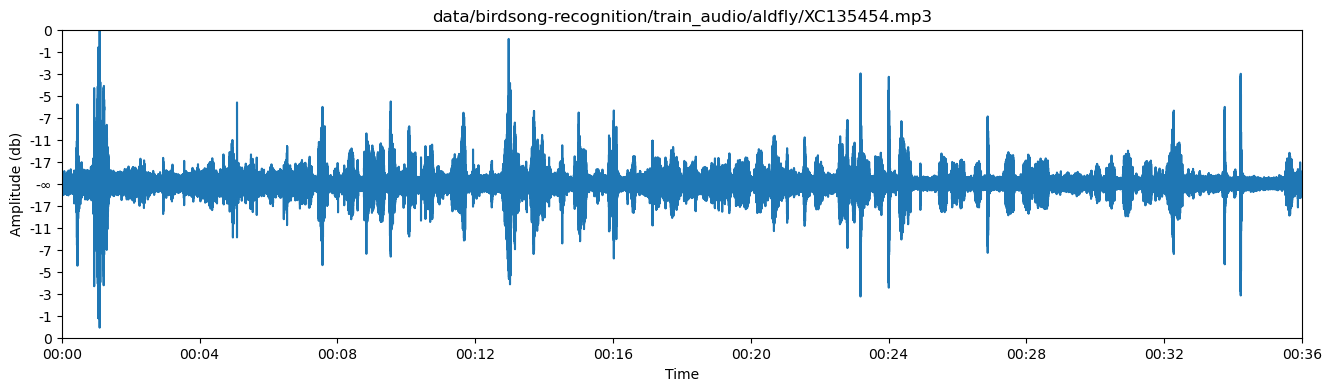

In [499]:
sound = AudioSegment.from_file(df.iloc[0].filename)
plot_waveform(sound, df.iloc[0].filename)

## Perform an STFT to make a Heatmap

In [500]:
def plot_specrogram(sound, title, scale='bark', normalization_constant=None):
    if sound.channels != 1:
        print('More than one channel, only using the first channel') 
        sound = sound.split_to_mono()[0]
    if scale not in ['log', 'mel', 'bark', 'erbs']:
        print('Invalid scale')
        return
    scale_function = None
    y_scale = 'linear'
    if scale == 'log':
        scale_function = lambda x: cp.array(x)
        y_scale = 'log'
    if scale == 'mel':
        scale_function = hz_to_mel
    if scale == 'bark':
        scale_function = hz_to_bark
    if scale == 'erbs':
        scale_function = hz_to_erbs
    signal = sound.get_array_of_samples()
    signal = normalize_signal(signal, normalization_constant)

    nperseg = sound.frame_rate // 10
    noverlap = nperseg // 2

    f, t, Zxx = cusig.stft(signal, fs=sound.frame_rate, nperseg=nperseg, noverlap=noverlap)

    f = scale_function(f)
    Zxx = magnitude_to_db(Zxx)
    plt.figure(figsize=(16, 4))
    plt.pcolormesh(t.get(), f.get(), Zxx.get(), cmap='plasma')
    plt.yscale(y_scale)
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    y_ticks = cp.array([20, 200, 500, 1000, 2000, 5000, 10000, 20000])
    plt.yticks(scale_function(y_ticks).get(), y_ticks.get())
    plt.ylim(scale_function(20).get(), scale_function(20000).get())
    plt.xlim(0, int(cp.max(t)))
    x_ticks = cp.linspace(0, int(cp.max(t)), 6).get()
    x_ticks_labels = [time_to_human_readable(x, depth=2) for x in x_ticks]
    plt.xlabel('Time')
    plt.xticks(x_ticks, x_ticks_labels)
    plt.clim(-120, 0)
    plt.colorbar()
    plt.show()

More than one channel, only using the first channel


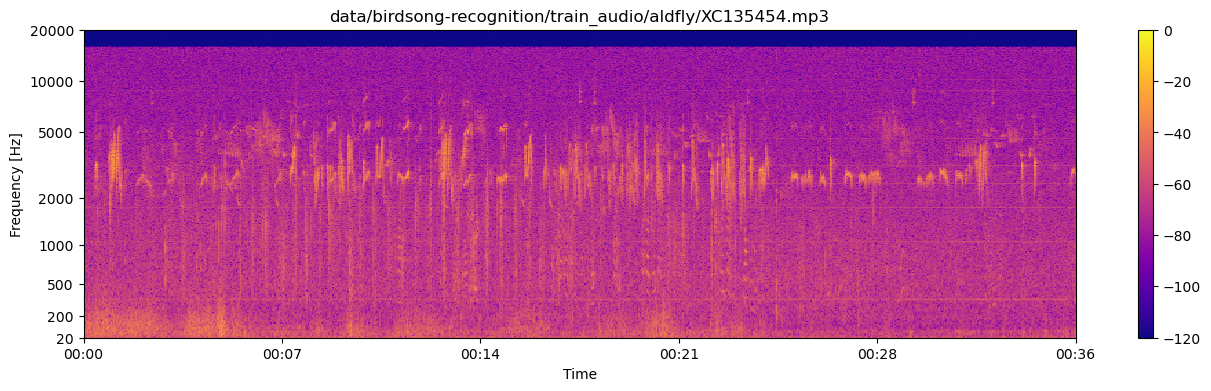

More than one channel, only using the first channel


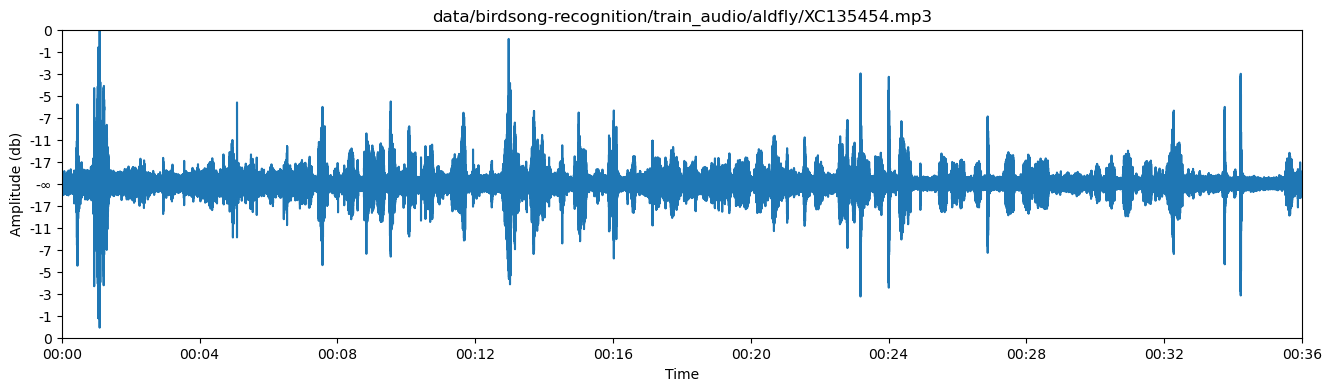

In [501]:
sound = AudioSegment.from_file(df.iloc[0].filename)
plot_specrogram(sound, df.iloc[0].filename)
plot_waveform(sound, df.iloc[0].filename)

## Prove the STFT is reversable without loss

NOLA: True
COLA: True
complex64


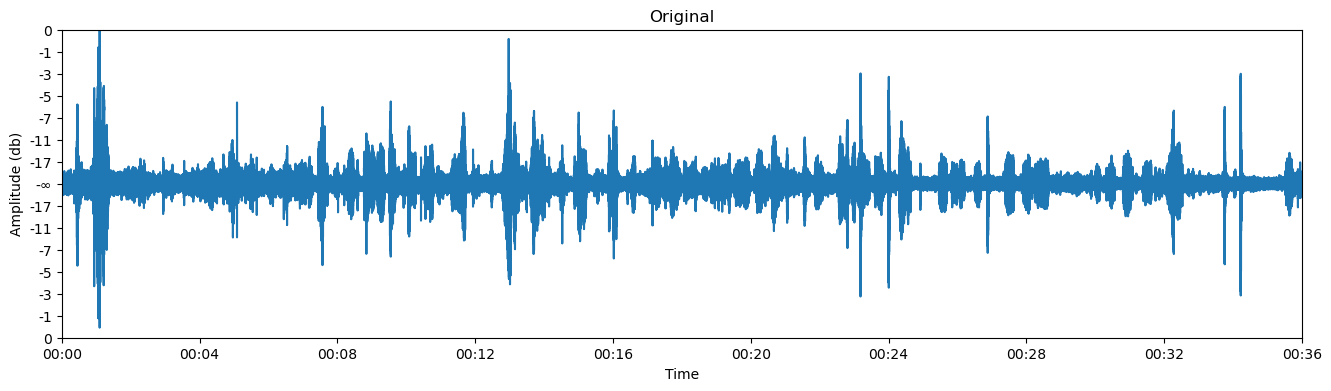

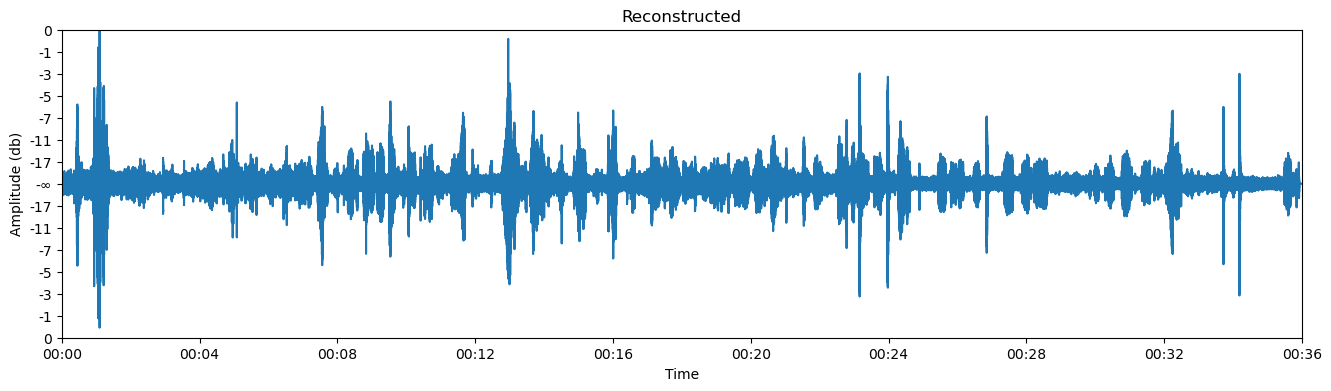

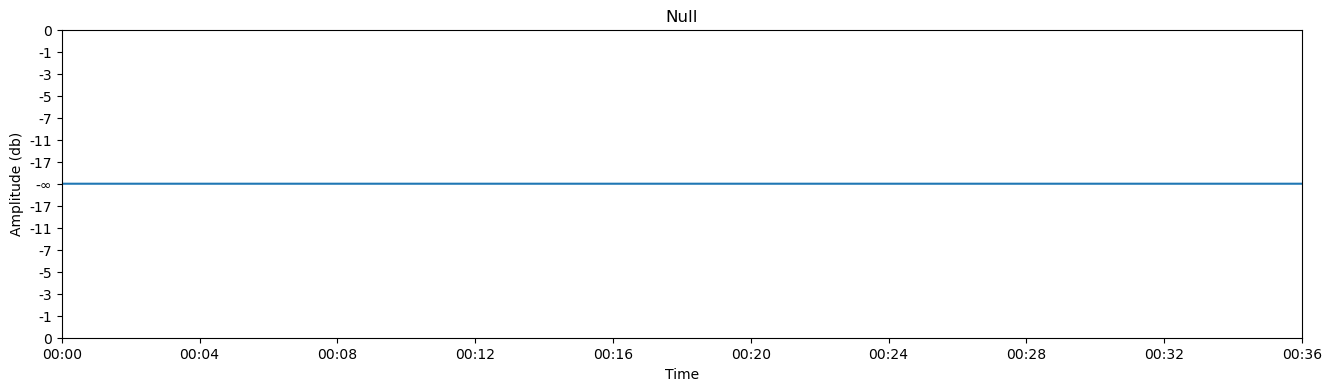

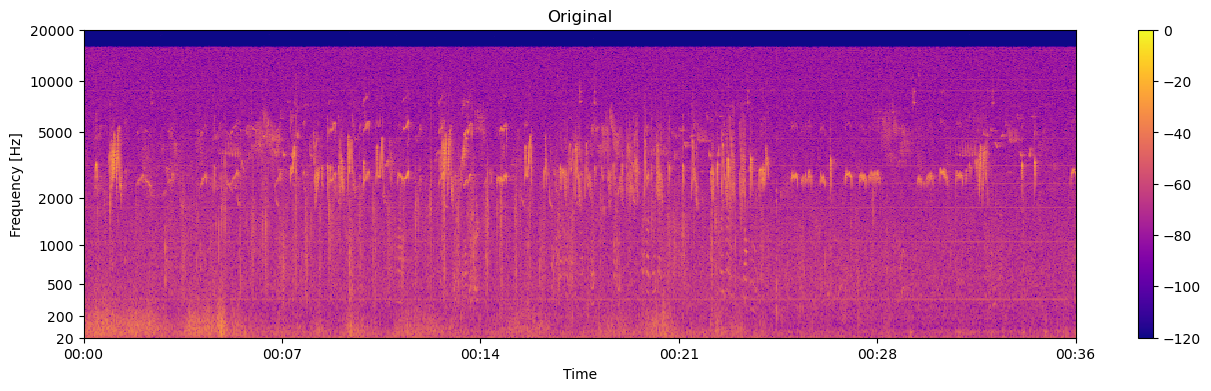

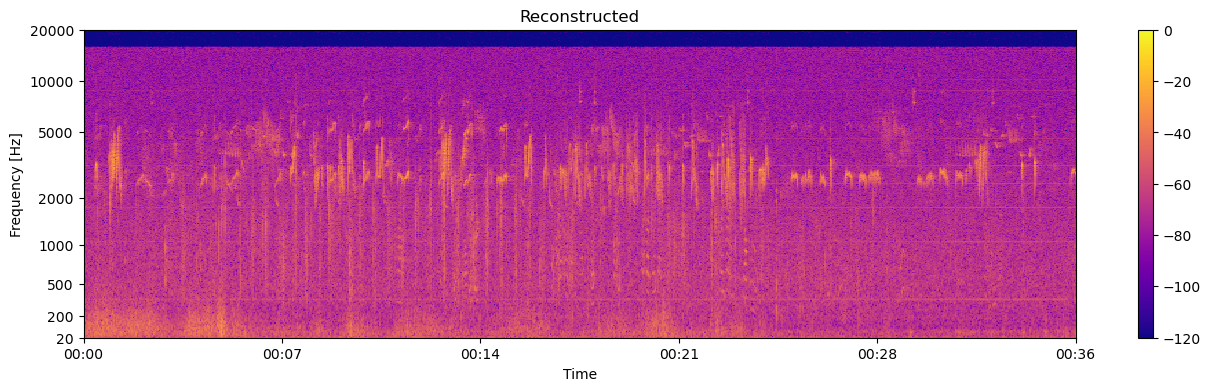

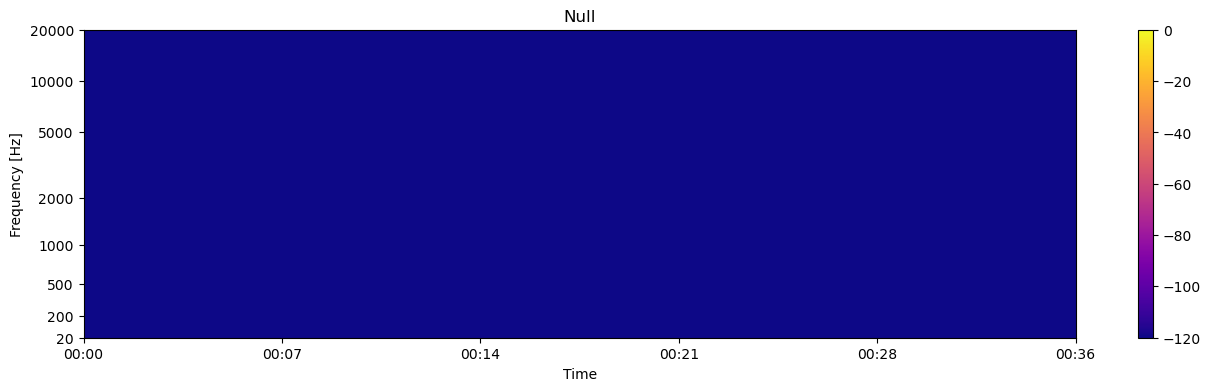

In [511]:
sound = AudioSegment.from_file(df.iloc[0].filename)
sound = sound.split_to_mono()[0]
signal = sound.get_array_of_samples()
nperseg = sound.frame_rate // 10
noverlap = nperseg // 2
print('NOLA:', cusig.check_NOLA('hann', nperseg, noverlap))
print('COLA:', cusig.check_COLA('hann', nperseg, noverlap))
f, t, Zxx = cusig.stft(signal, fs=sound.frame_rate, nperseg=nperseg, noverlap=noverlap)
print(Zxx.dtype)
t, new_signal = cusig.istft(Zxx, fs=sound.frame_rate, nperseg=nperseg, noverlap=noverlap)
new_signal = new_signal.get()
null_signal = signal - new_signal[:len(signal)]
null_signal = null_signal.astype(np.int16)
new_signal = new_signal.astype(np.int16)
null_sound = AudioSegment(
    null_signal.tobytes(),
    frame_rate=sound.frame_rate,
    sample_width=null_signal.dtype.itemsize,
    channels=1
)
null_sound.export('exports/null_sound.wav', format='wav')
new_sound = AudioSegment(
    new_signal.tobytes(),
    frame_rate=sound.frame_rate,
    sample_width=new_signal.dtype.itemsize,
    channels=1
)
normalization_constant = np.max(np.abs(signal))
plot_waveform(sound, 'Original', normalization_constant=normalization_constant)
plot_waveform(new_sound, 'Reconstructed', normalization_constant=normalization_constant)
plot_waveform(null_sound, 'Null', normalization_constant=normalization_constant)

plot_specrogram(sound, 'Original', normalization_constant=normalization_constant)
plot_specrogram(new_sound, 'Reconstructed', normalization_constant=normalization_constant)
plot_specrogram(null_sound, 'Null', normalization_constant=normalization_constant)

# Reprocess data
Gameplan:
for each audio file:
1. if there is silence in the audio file, split the file into multiple files by points of silence.
2. remove files shorter than 5 seconds.
3. perform a reversable stft on the file
4. find minimum values for each frequency bin
5. subtract the minimum values from each moment of time in the stft
6. perform a reverse stft to regenerate an audio file
7. search for transients by calculating rms over the signal chain and looking for disparities
8. reduce the volume of transients such that they do not vause a false maximum
9. normalize the amplitudes such that the maximum absolute amplitude in the file is 1
10. take the remaining file and cut it into appropreately sized 5 files
11. only make the file if there is a peak contained within speciic ranges inside the file, as to not fill some files with no birdcalls
12. what remains should be a series of 5 second files in which the noise floor has been reduces, and transients have been removed and the signal has been normalized to between -1 and 1.
This is the new training data.

In [ ]:
# Here comes the sun ladies and gentlemen.

def group_audio(df, duration_of_file=5):
    new_df = pd.DataFrame(columns=df.columns)
    if not os.path.exists('exports/reprocessed_audio'):
        os.makedirs('exports/reprocessed_audio')
    if os.path.exists('exports/reprocessed_audio/audio.csv'):
        new_df = pd.read_csv('exports/reprocessed_audio/audio.csv')
        return new_df
    for filename in df.filename.unique:
        sounds = AudioSegment.from_file(filename, format=mediainfo(filename)['format_name'])
        sounds = sounds.split_to_mono()
        cut_sounds = []
        for sound in sounds:
            last_cut = 0
            for i in range(len(sound)):
                if sound[i].rms == 0:
                    if i - last_cut < 5000:
                        last_cut = i
                        continue
                    cut_sounds.append(sound[last_cut:i])
                    last_cut = i
            if last_cut - len(sound) >= 5000:
                cut_sounds.append(sound[last_cut:])
        if len(cut_sounds) == 0:
            print('No cuts found for', filename)
            continue
        for cut_sound in cut_sounds:
            signal = cut_sound.get_array_of_samples()
            signal = cp.array(signal, dtype=cp.float32)
            nperseg = len(signal) // 10
            noverlap = nperseg // 2
            f, t, Zxx = cusig.stft(cut_sound.get_array_of_samples(), fs=cut_sound.frame_rate, npserseg=nperseg, noverlap=noverlap)
            minimum_spectrum = 
            for frequency in f:


            

SyntaxError: incomplete input (1794523061.py, line 8)

# Convert these signals into STFT heatmaps of normalized sized and not full frequency. This 2 dimentional map will be input data for a CNN